# Generate the needed plots

- Chia-Hao Lee, 2023.12.11 (modified on 2024.03.07 for zenodo update)
- cl2696@cornell.edu


## Plots 
- CBED stripe
- Ronchigram array
- Object array
- Resolution plot with probe
- SSIM plot


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tifffile import imread, imwrite, memmap

import scipy.io as sio
import abtem
import dask
from scipy import ndimage
abtem.config.set({"local_diagnostics.progress_bar": True})
abtem.config.set({"device": "gpu"})
abtem.config.set({"dask.chunk-size-gpu" : "512 MB"})
dask.config.set({"num_workers": 1})


In [2]:
import re
def natural_sort(lst):
    def natural_sort_key(s):
        def convert(text):
            return int(text) if text.isdigit() else text.lower()

        segments = [convert(segment) for segment in re.split('([0-9]+)', s)]
        return segments
    return sorted(lst, key=natural_sort_key)

In [3]:
def getFilename(dir, target_extension, keep_extension):
    '''
    This function go through the folder and return a list of filenames with the specific extension
    '''
    f_list = os.listdir(dir)
    file_list=[]
    for i in f_list:    
        if os.path.splitext(i)[1] == target_extension:
            if keep_extension:
                file_list.append(i)
            else:
                file_list.append(os.path.splitext(i)[0])
    file_list.sort()
    return file_list

In [4]:
# Create the 'fire' colormap
# https://www.mathworks.com/matlabcentral/fileexchange/35730-fire-and-or-custom-colormap-function
from io import StringIO
from matplotlib.colors import ListedColormap

# Create the custom colormap
fire_cmap_string = '''
         0         0         0
         0         0    0.0275
         0         0    0.0588
         0         0    0.0863
         0         0    0.1176
         0         0    0.1490
         0         0    0.1765
         0         0    0.2078
         0         0    0.2392
         0         0    0.2549
         0         0    0.2706
         0         0    0.2902
         0         0    0.3059
         0         0    0.3216
         0         0    0.3412
         0         0    0.3569
    0.0039         0    0.3765
    0.0157         0    0.3922
    0.0275         0    0.4078
    0.0392         0    0.4235
    0.0510         0    0.4431
    0.0627         0    0.4588
    0.0745         0    0.4745
    0.0863         0    0.4902
    0.0980         0    0.5098
    0.1098         0    0.5255
    0.1216         0    0.5412
    0.1333         0    0.5608
    0.1451         0    0.5765
    0.1569         0    0.5922
    0.1686         0    0.6118
    0.1804         0    0.6275
    0.1922         0    0.6471
    0.2039         0    0.6588
    0.2157         0    0.6706
    0.2275         0    0.6863
    0.2392         0    0.6980
    0.2510         0    0.7098
    0.2627         0    0.7255
    0.2745         0    0.7373
    0.2863         0    0.7529
    0.2980         0    0.7647
    0.3098         0    0.7804
    0.3216         0    0.7922
    0.3333         0    0.8078
    0.3451         0    0.8196
    0.3569         0    0.8353
    0.3686         0    0.8471
    0.3843         0    0.8627
    0.3961         0    0.8627
    0.4078         0    0.8667
    0.4196         0    0.8706
    0.4314         0    0.8745
    0.4431         0    0.8784
    0.4549         0    0.8824
    0.4667         0    0.8863
    0.4784         0    0.8902
    0.4902         0    0.8784
    0.5020         0    0.8706
    0.5137         0    0.8627
    0.5255         0    0.8549
    0.5373         0    0.8471
    0.5490         0    0.8392
    0.5608         0    0.8314
    0.5725         0    0.8235
    0.5804         0    0.8078
    0.5882         0    0.7922
    0.5961         0    0.7804
    0.6039         0    0.7647
    0.6118         0    0.7490
    0.6196         0    0.7373
    0.6275         0    0.7216
    0.6353         0    0.7098
    0.6392         0    0.6941
    0.6431         0    0.6784
    0.6510         0    0.6627
    0.6549         0    0.6510
    0.6588         0    0.6353
    0.6667         0    0.6196
    0.6706         0    0.6039
    0.6784         0    0.5922
    0.6824         0    0.5765
    0.6863         0    0.5608
    0.6941         0    0.5490
    0.6980         0    0.5333
    0.7020         0    0.5176
    0.7098         0    0.5059
    0.7137         0    0.4902
    0.7216         0    0.4784
    0.7255         0    0.4627
    0.7294         0    0.4471
    0.7373         0    0.4353
    0.7412         0    0.4196
    0.7451         0    0.4039
    0.7529         0    0.3922
    0.7569         0    0.3765
    0.7647         0    0.3647
    0.7686    0.0039    0.3490
    0.7765    0.0118    0.3333
    0.7804    0.0196    0.3216
    0.7882    0.0275    0.3059
    0.7922    0.0314    0.2902
    0.8000    0.0392    0.2784
    0.8039    0.0471    0.2627
    0.8118    0.0549    0.2510
    0.8157    0.0627    0.2353
    0.8196    0.0745    0.2196
    0.8235    0.0824    0.2078
    0.8314    0.0941    0.1922
    0.8353    0.1059    0.1765
    0.8392    0.1137    0.1647
    0.8431    0.1255    0.1490
    0.8510    0.1373    0.1373
    0.8549    0.1451    0.1216
    0.8627    0.1569    0.1059
    0.8667    0.1686    0.0902
    0.8745    0.1804    0.0784
    0.8784    0.1882    0.0627
    0.8863    0.2000    0.0471
    0.8902    0.2118    0.0314
    0.8980    0.2235    0.0196
    0.9020    0.2314    0.0157
    0.9059    0.2431    0.0118
    0.9137    0.2549    0.0118
    0.9176    0.2667    0.0078
    0.9216    0.2745    0.0039
    0.9294    0.2863    0.0039
    0.9333    0.2980         0
    0.9412    0.3098         0
    0.9451    0.3176         0
    0.9529    0.3294         0
    0.9569    0.3412         0
    0.9647    0.3529         0
    0.9686    0.3608         0
    0.9765    0.3725         0
    0.9804    0.3843         0
    0.9882    0.3961         0
    0.9882    0.4039         0
    0.9882    0.4118         0
    0.9922    0.4196         0
    0.9922    0.4275         0
    0.9922    0.4353         0
    0.9961    0.4431         0
    0.9961    0.4510         0
    1.0000    0.4588         0
    1.0000    0.4667         0
    1.0000    0.4745         0
    1.0000    0.4824         0
    1.0000    0.4902         0
    1.0000    0.4980         0
    1.0000    0.5059         0
    1.0000    0.5137         0
    1.0000    0.5216         0
    1.0000    0.5255         0
    1.0000    0.5333         0
    1.0000    0.5412         0
    1.0000    0.5490         0
    1.0000    0.5529         0
    1.0000    0.5608         0
    1.0000    0.5686         0
    1.0000    0.5765         0
    1.0000    0.5804         0
    1.0000    0.5882         0
    1.0000    0.5961         0
    1.0000    0.6039         0
    1.0000    0.6078         0
    1.0000    0.6157         0
    1.0000    0.6235         0
    1.0000    0.6314         0
    1.0000    0.6353         0
    1.0000    0.6431         0
    1.0000    0.6510         0
    1.0000    0.6588         0
    1.0000    0.6627         0
    1.0000    0.6706         0
    1.0000    0.6784         0
    1.0000    0.6863         0
    1.0000    0.6902         0
    1.0000    0.6980         0
    1.0000    0.7059         0
    1.0000    0.7137         0
    1.0000    0.7216         0
    1.0000    0.7294         0
    1.0000    0.7373         0
    1.0000    0.7451         0
    1.0000    0.7490         0
    1.0000    0.7569         0
    1.0000    0.7647         0
    1.0000    0.7725         0
    1.0000    0.7804         0
    1.0000    0.7882         0
    1.0000    0.7961         0
    1.0000    0.8039         0
    1.0000    0.8078         0
    1.0000    0.8157         0
    1.0000    0.8235         0
    1.0000    0.8314         0
    1.0000    0.8353         0
    1.0000    0.8431         0
    1.0000    0.8510         0
    1.0000    0.8588         0
    1.0000    0.8627         0
    1.0000    0.8706         0
    1.0000    0.8784         0
    1.0000    0.8863         0
    1.0000    0.8941         0
    1.0000    0.9020         0
    1.0000    0.9098         0
    1.0000    0.9176         0
    1.0000    0.9216    0.0157
    1.0000    0.9294    0.0314
    1.0000    0.9373    0.0510
    1.0000    0.9451    0.0667
    1.0000    0.9490    0.0824
    1.0000    0.9569    0.1020
    1.0000    0.9647    0.1176
    1.0000    0.9725    0.1373
    1.0000    0.9725    0.1647
    1.0000    0.9765    0.1961
    1.0000    0.9804    0.2275
    1.0000    0.9843    0.2588
    1.0000    0.9882    0.2902
    1.0000    0.9922    0.3216
    1.0000    0.9961    0.3529
    1.0000    1.0000    0.3843
    1.0000    1.0000    0.4118
    1.0000    1.0000    0.4431
    1.0000    1.0000    0.4745
    1.0000    1.0000    0.5059
    1.0000    1.0000    0.5333
    1.0000    1.0000    0.5647
    1.0000    1.0000    0.5961
    1.0000    1.0000    0.6275
    1.0000    1.0000    0.6549
    1.0000    1.0000    0.6863
    1.0000    1.0000    0.7176
    1.0000    1.0000    0.7490
    1.0000    1.0000    0.7804
    1.0000    1.0000    0.8118
    1.0000    1.0000    0.8431
    1.0000    1.0000    0.8745
    1.0000    1.0000    0.8902
    1.0000    1.0000    0.9059
    1.0000    1.0000    0.9216
    1.0000    1.0000    0.9373
    1.0000    1.0000    0.9529
    1.0000    1.0000    0.9686
    1.0000    1.0000    0.9843
    1.0000    1.0000    1.0000
    1.0000    1.0000    1.0000
    1.0000    1.0000    1.0000
    1.0000    1.0000    1.0000
    1.0000    1.0000    1.0000
    1.0000    1.0000    1.0000
    1.0000    1.0000    1.0000
    1.0000    1.0000    1.0000
    '''

fire_cmap_array = np.genfromtxt(StringIO(fire_cmap_string), dtype=float)
fire_cmap = ListedColormap(fire_cmap_array, name='fire')


# 01. CBED stripes

In [5]:
# Load images
cbed_01_path = 'data/20231129_abTEM_realistic_ptycho_simu/static_coherent/alpha_10.5mrad/Cs_1.0mm/CBED_00000.tif'
cbed_02_path = 'data/20231129_abTEM_realistic_ptycho_simu/phonon_coherent/alpha_10.5mrad/Cs_1.0mm/CBED_00000.tif'
cbed_01 = imread(cbed_01_path)
cbed_02 = imread(cbed_02_path)
labels = ['static', 'phonon']

In [6]:
stripe_width = 114
center = np.array(cbed_01.shape[0])//2
cbed_stripe_01 = cbed_01[:center, center-stripe_width//2:center+stripe_width//2]
cbed_stripe_02 = cbed_02[:center, center-stripe_width//2:center+stripe_width//2]

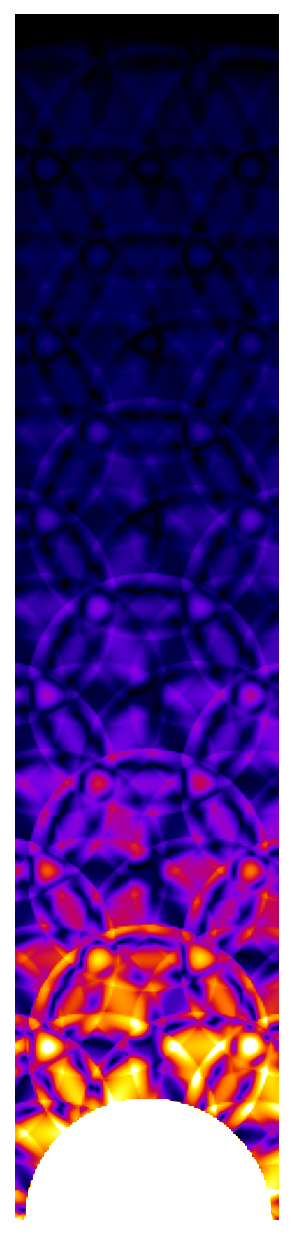

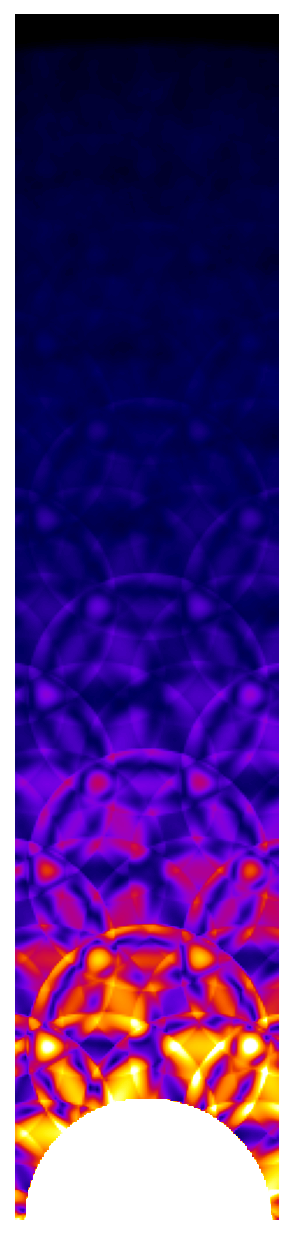

In [7]:
for i, cbed_stripe in enumerate([cbed_stripe_01, cbed_stripe_02]):
    fig, ax = plt.subplots(figsize=(cbed_stripe.shape[1] / 50, cbed_stripe.shape[0] / 50), dpi=150)
    image = ax.imshow(np.sqrt(cbed_stripe), vmax=0.1, cmap=fire_cmap)
    #cbar = plt.colorbar(image, ax=ax)
    ax.axis('off')  # Turn off ticks and axis labels

    # Save the figure without extra white space

    plt.savefig('figure_components/Fig_S3_20231129_Cs_1.0mm_10.5mrad_cbed_stripe_' + labels[i] + '.png', bbox_inches='tight', pad_inches=0)

    # Show the plot if needed
    plt.show()

# 02. Ronchigrams array

In [8]:
data_dir = 'data/20231203_ptycho_recon_kmax2'
simu_modes = ['static_coherent', 'phonon_coherent', 'phonon_temporal', 'phonon_spatial', 'phonon_temporal_spatial']
folder_pattern = 'data3D_200kV_df_10nm_alpha_10.5mrad_Cs_1.0mm_'
detector_modes = ['dp_512_blur_0px_dose_1.0e+14ePerAng2/1/data_roi_1_Ndp_512_dp.tif', 
                   'dp_256_blur_0px_dose_1.0e+14ePerAng2/1/data_roi_1_Ndp_256_dp.tif',
                   'dp_128_blur_0px_dose_1.0e+14ePerAng2/1/data_roi_1_Ndp_128_dp.tif', 
                   'dp_128_blur_0.5px_dose_1.0e+14ePerAng2/1/data_roi_1_Ndp_128_dp.tif', 
                   'dp_128_blur_0.5px_dose_1.0e+06ePerAng2/1/data_roi_1_Ndp_128_dp.tif']

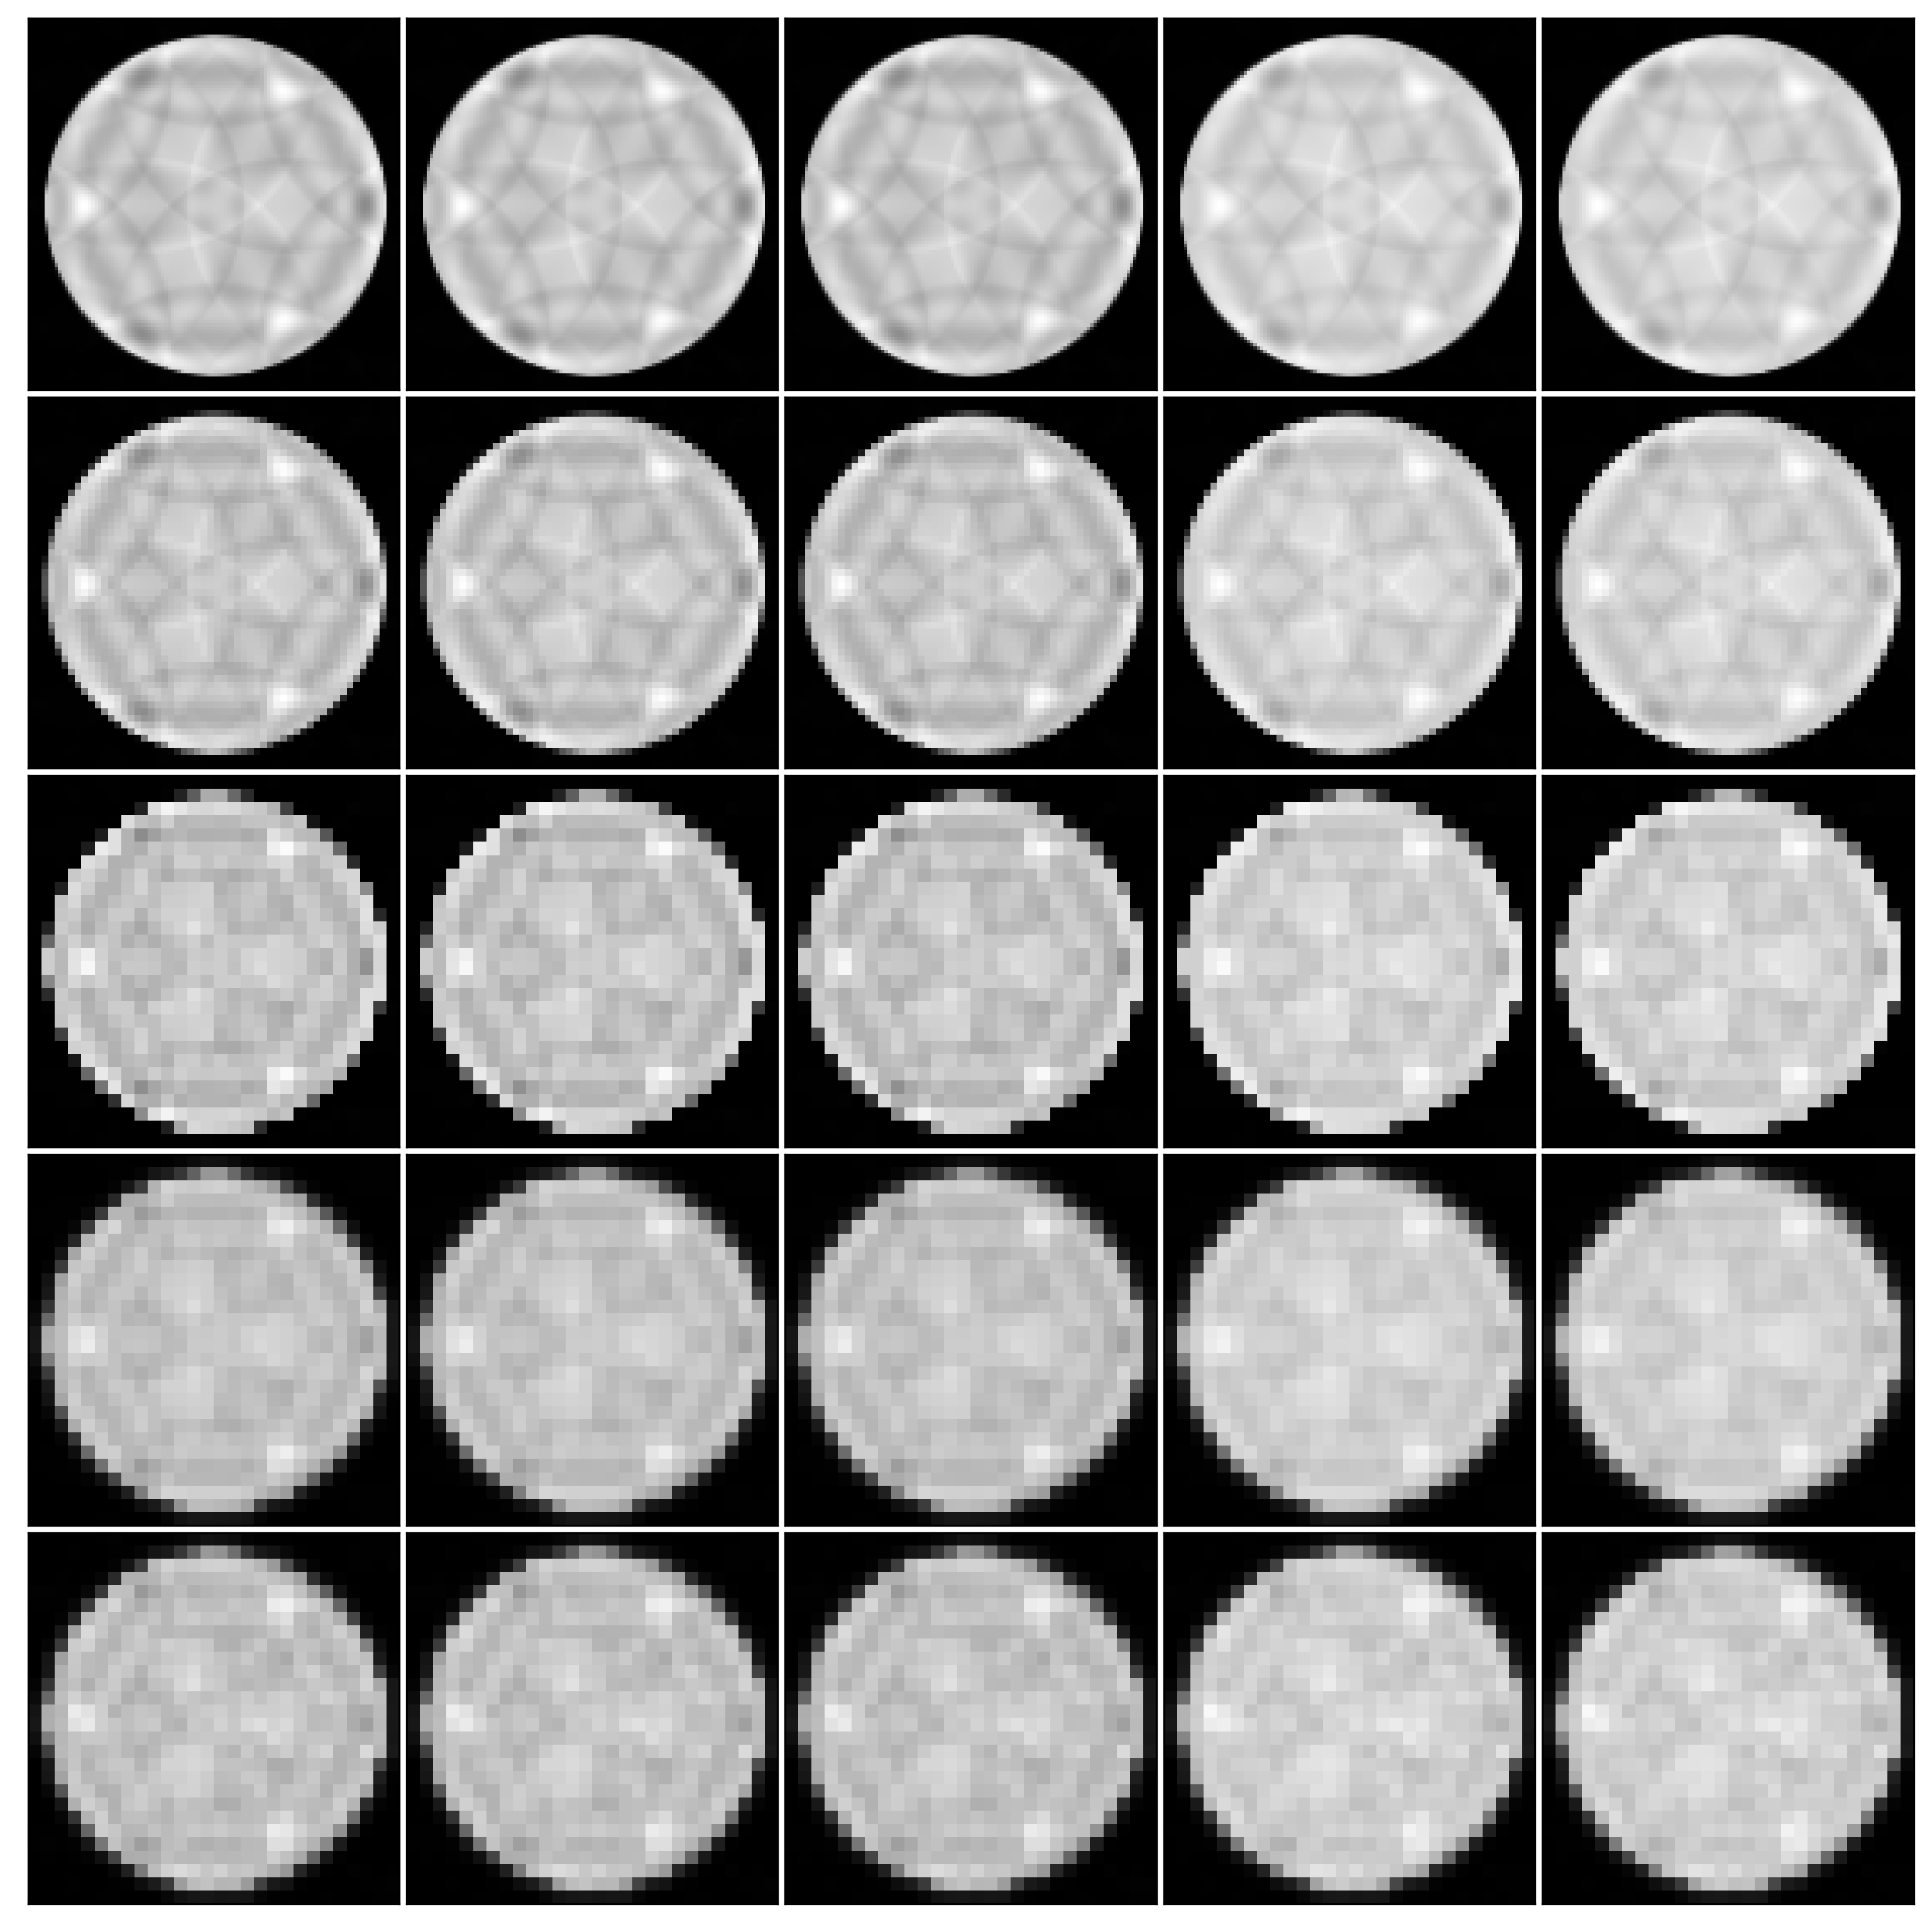

In [9]:
fig, axs = plt.subplots(5,5,figsize=(10, 10), dpi=300)
plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Adjust the gap here

for i in range(len(detector_modes)):
    for j in range (len(simu_modes)):
        
        cbed_path = os.path.join(data_dir, simu_modes[j], folder_pattern+detector_modes[i])
        cbed = imread(os.path.join(data_dir, simu_modes[j], folder_pattern+detector_modes[i])) # The archive DP data are reduced to 1st slice only. I was using memmap to read the 1st slice from an actual 4D-STEM dataset.
        
        center = cbed.shape[0]//2
        window_length = int(cbed.shape[0]/4.5)
        ronchi = cbed[center-window_length//2:center+window_length//2, center-window_length//2:center+window_length//2]
        axs[i,j].imshow(ronchi, cmap='gray', vmax=1)

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove outer white space
plt.savefig('figure_components/Fig_S3_20231203_kmax2_Cs_1.0mm_10.5mrad_ronchis_gray_5rows.png',bbox_inches='tight', pad_inches=0)
plt.show()

# 03.01 Ptycho Object array (coherence mode and detector modes)

In [10]:
data_dir = 'data/20231203_ptycho_recon_kmax2'
simu_modes = ['static_coherent', 'phonon_coherent', 'phonon_temporal', 'phonon_spatial', 'phonon_temporal_spatial']
folder_pattern = 'data3D_200kV_df_10nm_alpha_10.5mrad_Cs_1.0mm_'

detector_modes = ['dp_512_blur_0px_dose_1.0e+14ePerAng2/1/roi_1_Ndp_512\MLs_L1_p16_g64_dpFlip_T\obj_phase_roi/obj_phase_roi_Niter500.tiff', 
                  'dp_256_blur_0px_dose_1.0e+14ePerAng2/1/roi_1_Ndp_256\MLs_L1_p16_g64_dpFlip_T\obj_phase_roi/obj_phase_roi_Niter500.tiff',
                  'dp_128_blur_0px_dose_1.0e+14ePerAng2/1/roi_1_Ndp_128\MLs_L1_p16_g64_dpFlip_T\obj_phase_roi/obj_phase_roi_Niter500.tiff', 
                  'dp_128_blur_0.5px_dose_1.0e+14ePerAng2/1/roi_1_Ndp_128\MLs_L1_p16_g64_dpFlip_T\obj_phase_roi/obj_phase_roi_Niter500.tiff', 
                  'dp_128_blur_0.5px_dose_1.0e+06ePerAng2/1/roi_1_Ndp_128\MLs_L1_p16_g64_dpFlip_T\obj_phase_roi/obj_phase_roi_Niter500.tiff']

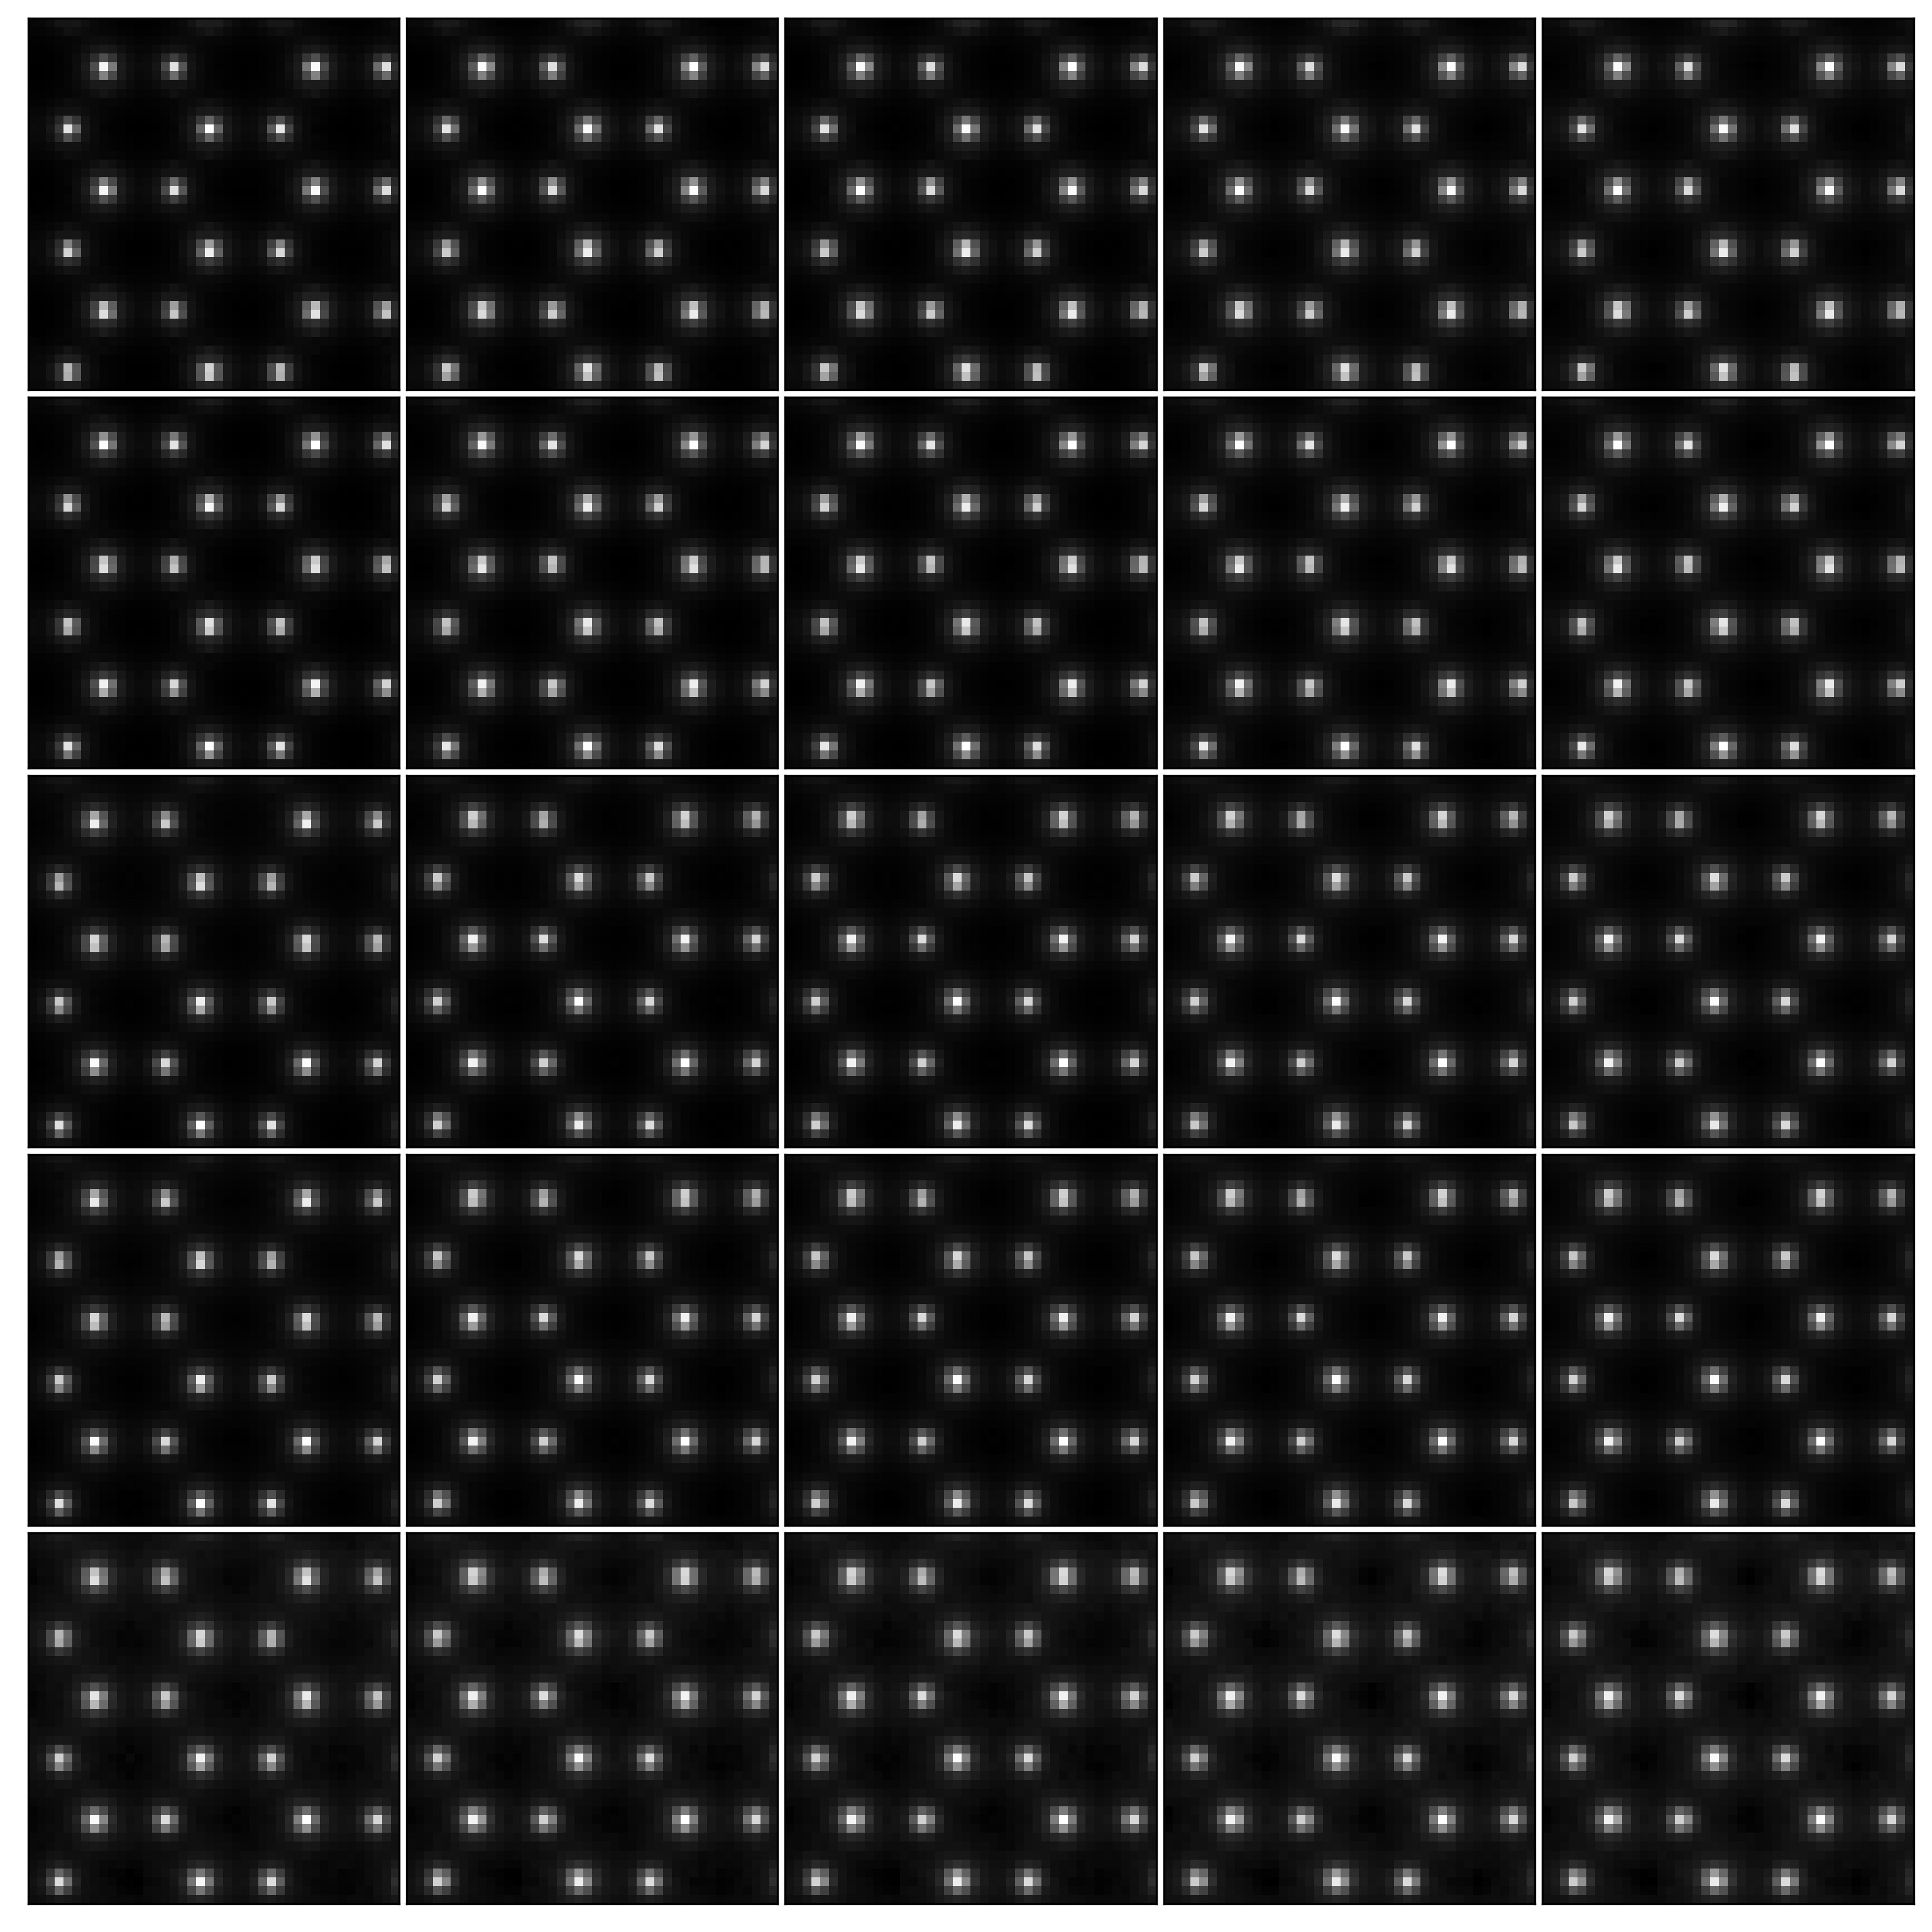

In [11]:
fig, axs = plt.subplots(5,5,figsize=(10, 10), dpi=300)
plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Adjust the gap here

for i in range(len(detector_modes)):
    for j in range (len(simu_modes)):
        
        ptycho_obj_path = os.path.join(data_dir, simu_modes[j], folder_pattern+detector_modes[i])
       
        ptycho_obj = imread(ptycho_obj_path)
        center = ptycho_obj.shape[0]//2
        window_length = ptycho_obj.shape[0]//3
        crop_obj = ptycho_obj[center-window_length//2:center+window_length//2, center-window_length//2:center+window_length//2]
        axs[i,j].imshow(crop_obj, cmap='gray')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove outer white space
plt.savefig('figure_components/Fig_S4_20231203_kmax2_Cs_1.0mm_10.5mrad_obj_p16_Niter500_5rows.png',bbox_inches='tight', pad_inches=0)
plt.show()

# 03.02 Ptycho Object array (coherence mode and convergence angles)

In [12]:
data_dir = 'data/20231203_ptycho_recon_kmax4'
simu_modes = ['static_coherent', 'phonon_coherent', 'phonon_temporal', 'phonon_spatial', 'phonon_temporal_spatial']
folder_patterns = ['data3D_200kV_df_10nm_alpha_10.5mrad_Cs_1.0mm_',
                  'data3D_200kV_df_10nm_alpha_23.1mrad_Cs_1.0mm_',
                  'data3D_200kV_df_10nm_alpha_40.0mrad_Cs_1.0mm_'] 
detector_modes = ['dp_1024_blur_0px_dose_1.0e+07ePerAng2/1/roi_1_Ndp_1024\MLs_L1_p16_g16_dpFlip_T\obj_phase_roi/obj_phase_roi_Niter500.tiff']

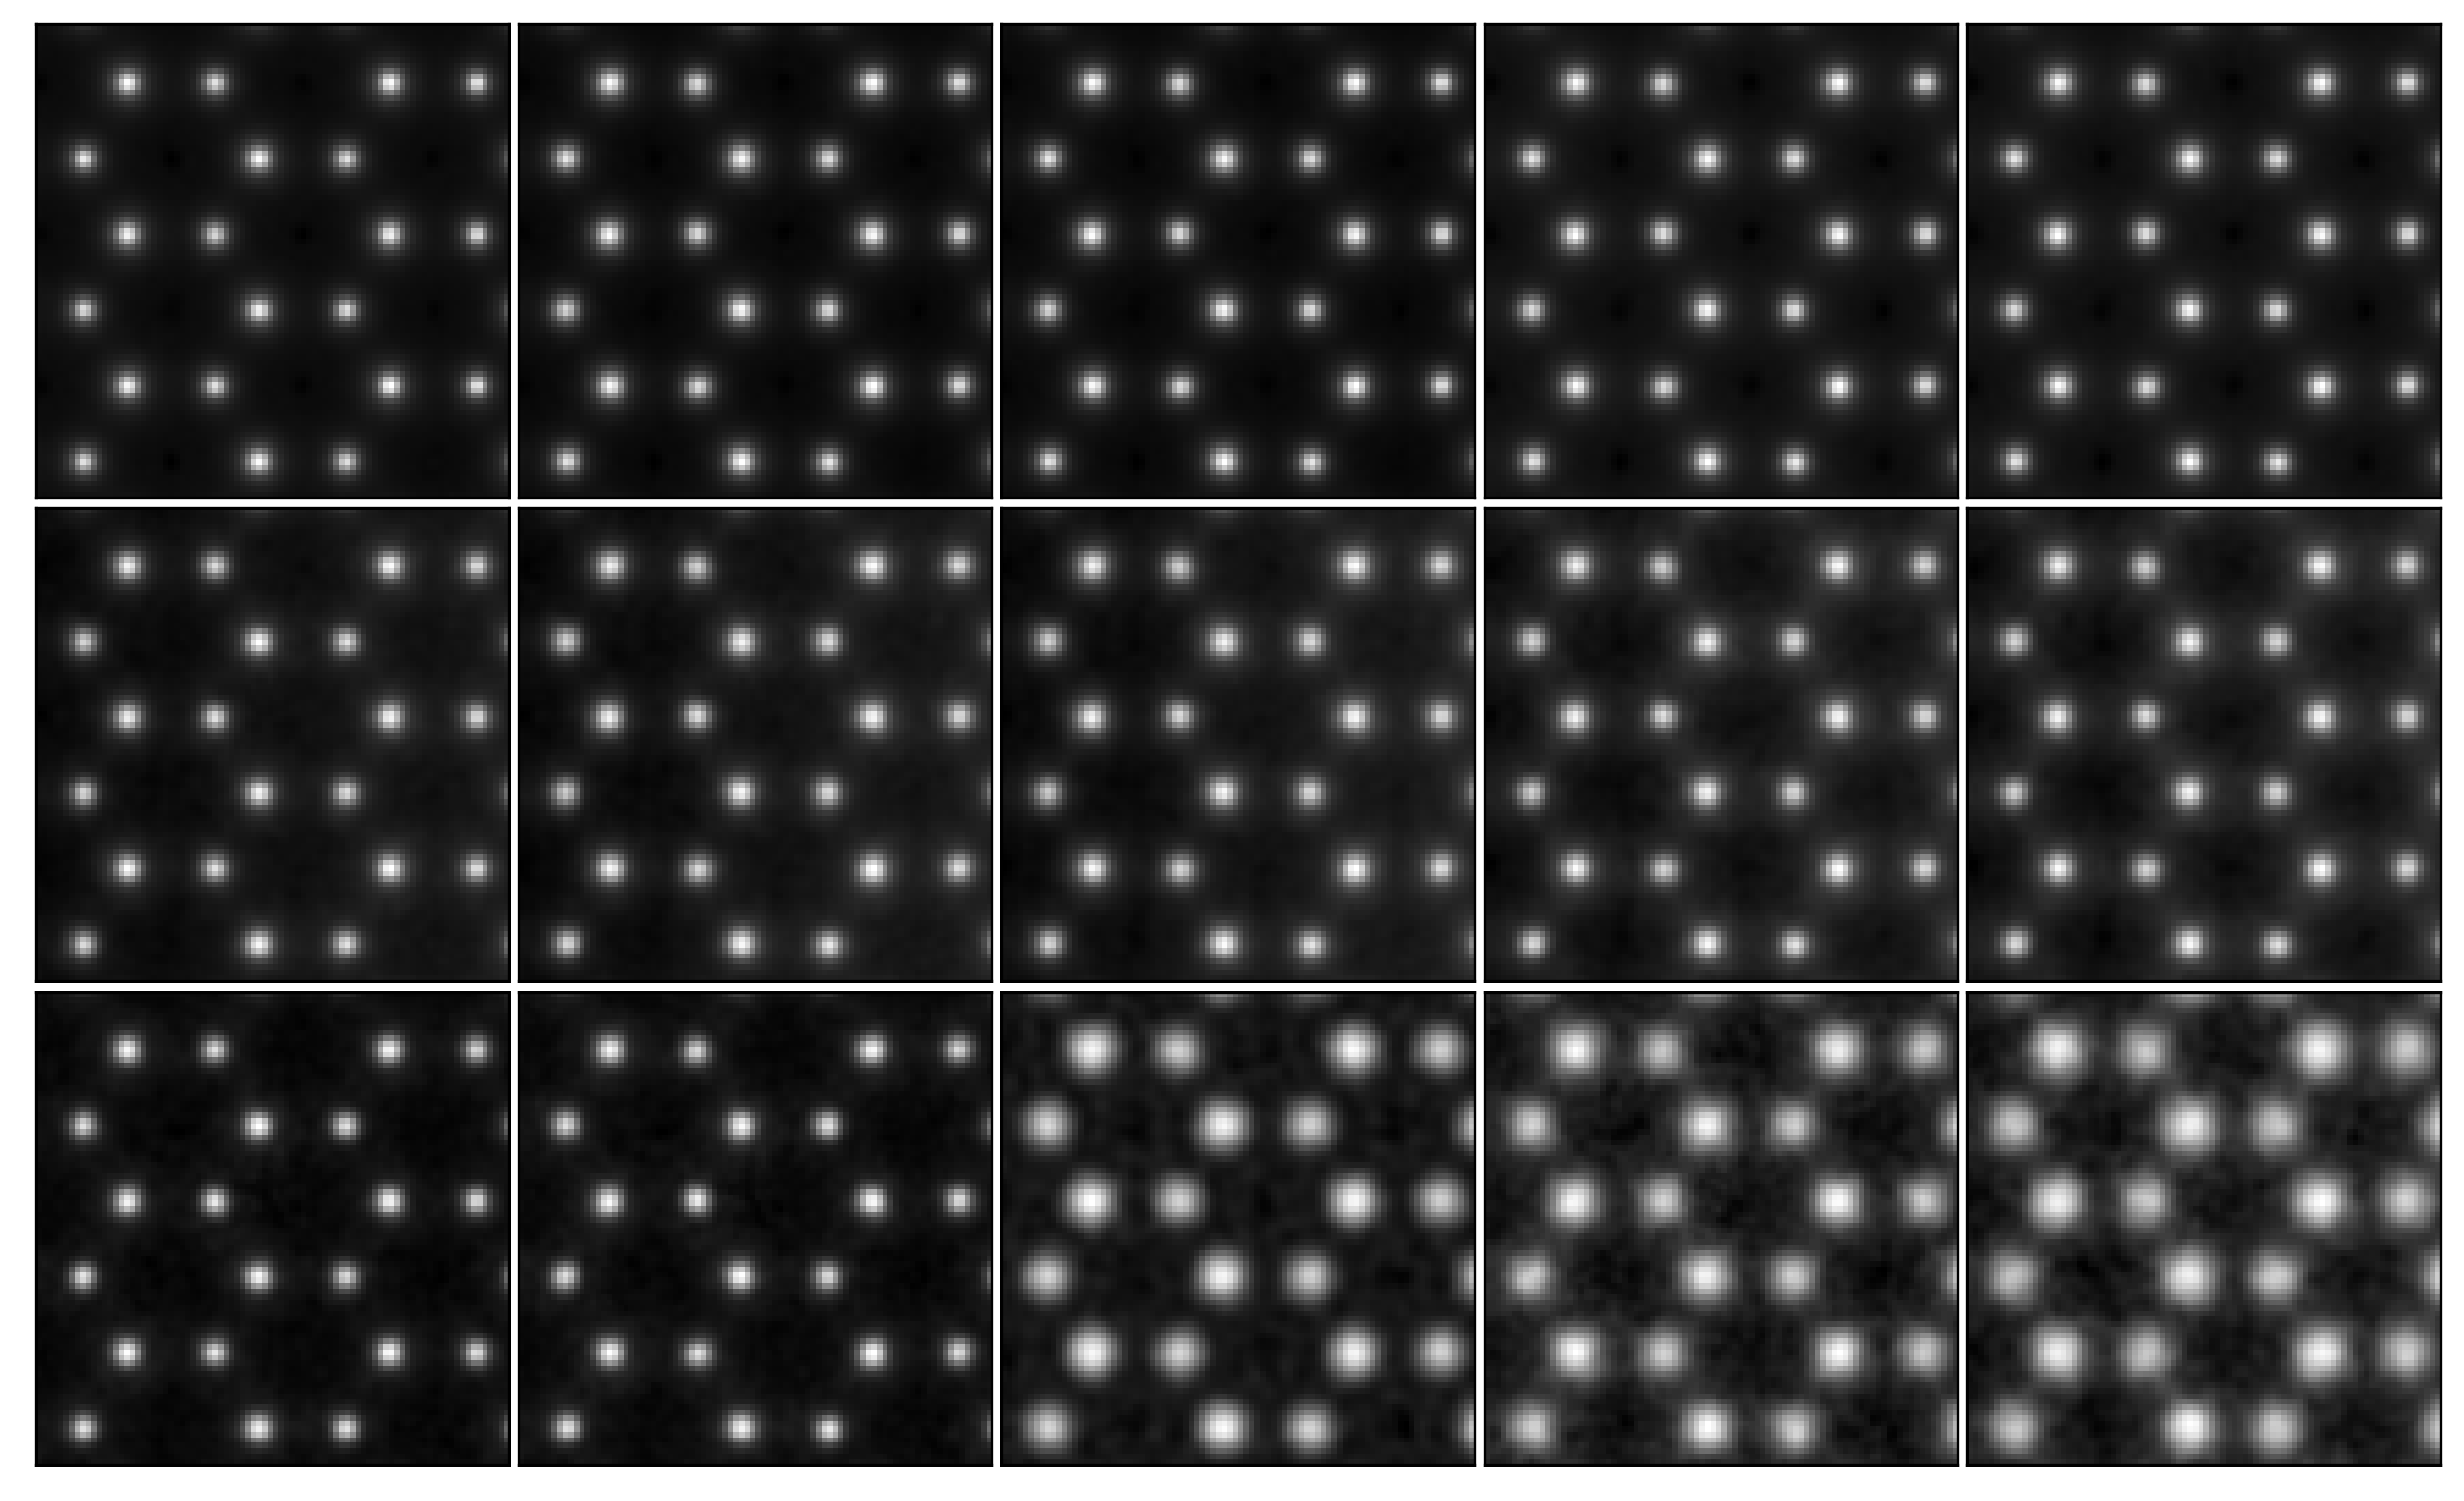

In [13]:
fig, axs = plt.subplots(3,5,figsize=(10, 6), dpi=300)
plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Adjust the gap here

for i in range(len(folder_patterns)):
    for j in range (len(simu_modes)):
        
        ptycho_obj_path = os.path.join(data_dir, simu_modes[j], folder_patterns[i]+detector_modes[0])
        ptycho_obj = imread(ptycho_obj_path)
        center = ptycho_obj.shape[0]//2
        window_length = ptycho_obj.shape[0]//3
        crop_obj = ptycho_obj[center-window_length//2:center+window_length//2, center-window_length//2:center+window_length//2]
        axs[i,j].imshow(crop_obj, cmap='gray')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove outer white space
plt.savefig('figure_components/Fig_S5_20231203_kmax4_Cs_1.0mm_3_angles_obj_p16_Niter500_3rows.png',bbox_inches='tight', pad_inches=0)
plt.show()

# 04.01 Simulate STEM probes for the resolution plot

In [14]:
def get_blob_size(dx, blob, plot_profile):
    """ Get the probe / blob size

    Args:
        dx (float): px size in Ang
        blob (array): the probe/blob image, note that we assume the input is already directly measurable and no squaring is needed, centered, and background free
        plot_profile (bool): Flag for plotting the profile or not 

    Returns:
        D50*dx: D50 in Ang
        D90*dx: D90 in Ang
        radius_rms*dx: RMS radius in Ang
        radial_profile: radially averaged profile
        radial_sum: radial profile without normalizing by the ring area
        fig: Line profile figure
    """
    def get_radial_profile(data, center):
        # The radial intensity is calculated up to the corners
        # So len(radialprofile) will be len(data)/sqrt(2)
        # The bin width is set to be the same with original data spacing (dr = dx)
        y, x = np.indices((data.shape))
        r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
        r = r.astype(int)
        tbin = np.bincount(r.ravel(), data.ravel())
        nr = np.bincount(r.ravel())
        radial_profile = tbin / nr
        radial_sum = tbin
        return radial_profile, radial_sum

    radial_profile, radial_sum = get_radial_profile(blob, (len(blob)//2, len(blob)//2))
    #print("sum(radial_sum) = %.5f " %(np.sum(radial_sum)))

    # Calculate the rms radius, in px
    x = np.arange(len(radial_profile))
    radius_rms = np.sqrt(np.sum(x**2*radial_profile*x)/np.sum(radial_profile*x))

    # Calculate FWHM
    
    HWHM = np.max(np.where((radial_profile / radial_profile.max()) >=0.5))
    
    # Calculate D50, D90
    cum_sum = np.cumsum(radial_sum)

    # R50, 90 without normalization
    R50 = np.min(np.where(cum_sum>=0.50*np.sum(radial_sum))[0])
    R90 = np.min(np.where(cum_sum>=0.90*np.sum(radial_sum))[0])

    D50 = (2*R50+1)
    D90 = (2*R90+1)
    FWHM = (2*HWHM+1)
    #print('D50 = %s px or %.4f Ang' %(D50, D50*dx))
    #print('D90 = %s px or %.4f Ang' %(D90, D90*dx))

    fig = None
    if plot_profile:
        
        num_ticks = 11
        x = dx*np.arange(len(radial_profile))
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.title("Radially averaged profile")
        plt.margins(x=0, y=0)
        ax.plot(x, radial_profile/np.max(radial_profile), label='Radially averaged profile')
        #plt.plot(x, cum_sum, 'k--', label='Integrated current')
        plt.vlines(x=R50*dx, ymin=0, ymax=1, color="tab:orange", linestyle=":", label='R50') #Draw vertical lines at the data coordinate, in this case would be Ang.
        plt.vlines(x=R90*dx, ymin=0, ymax=1, color="tab:red", linestyle=":", label='R90')
        plt.vlines(x=HWHM*dx, ymin=0, ymax=1, color="tab:red", linestyle=":", label='R90')
        plt.vlines(x=radius_rms*dx, ymin=0, ymax=1, color="tab:green", linestyle=":", label='Radius_RMS')
        plt.xticks(np.arange(num_ticks)*np.round(len(radial_profile)*dx/num_ticks, decimals = 1-int(np.floor(np.log10(len(radial_profile)*dx)))))
        ax.set_xlabel("Distance from blob center ($\AA$)")
        ax.set_ylabel("Normalized intensity")
        plt.legend()
        plt.close(fig)
        #plt.show()

    return D50*dx, D90*dx, radius_rms*dx, FWHM*dx, radial_profile, radial_sum, fig

In [15]:
# Simulate STEM probe with partial coherence

real_space_sampling = 0.08/2 # unit: Ang, note that kmax_antialias = 1/(3*dx), so if we want to simulate up to kmax = 4.1 1/Ang, we need 1/4.1/3 Ang sampling or slightly finer ~ 0.08 Ang 

# Probe parameters
energy = 200e3 # unit: eV
wavelength = 0.025079 # unit: Ang, this value is only used for display useful information
convergence_angles = [1,3,5,7.5,9.5,10.5,12,15,18, 20, 22, 23.1, 24, 26, 28, 30, 32, 34, 36, 38, 40] # unit: mrad
df = 0 # df, unit: Ang, note the df = -C1,0, so positive defocus is underfocuse just like Kirkland and fold_slice.
C30_list = [1 * 1e-6 * 1e10, 1.1 * 1e-3 * 1e10] # unit: Ang, note that we convert to m and then Ang. C30 = Cs.
aberrations = {"C30": C30_list}
extent = 126 # Ang

# Temporal partial coherence
chromatic_aberration = 1 * 1e-3 * 1e10 # unit: Ang, note that we convert to m and then Ang
energy_spread = 0.35 # unit: eV, this is the std so expected FWHM of ZLP would be 2.355*0.35 ~ 0.82 eV
num_df_configs = 9

# Spatial parital coherence
spatial_blur_std = 0.8/2.355 # Unit: Ang, the idea is to get equivalently 0.8 Ang FWHM source size blurring. FWHM = 2.355 sigma.

# Output directory
output_dir = 'data/Fig_3a_abTEM_simulated_STEM_probes'

In [16]:
kmax_antialias = 1/real_space_sampling/3 # 1/Ang #The kmax_antialiasing = 4.166 Ang-1 
alpha_max_antialias = wavelength * kmax_antialias # rad
focal_spread = chromatic_aberration * energy_spread / energy

defocus_distribution = abtem.distributions.gaussian(
    center = df,
    standard_deviation=focal_spread,
    num_samples=num_df_configs,
    sampling_limit=2,
    ensemble_mean=True)
print(f"Energy = {energy/1e3} kV, rel. wavelength = {wavelength} Ang")
print(f"CBED collection kmax = {kmax_antialias} 1/Ang, collection alpha_max = {alpha_max_antialias*1000} mrad")
print(f"Focal spread = {focal_spread} Å")
print(f"defocus distribution = {np.array(defocus_distribution)}")

probe_coherent = abtem.Probe(energy=energy, semiangle_cutoff=convergence_angles, defocus=df,                   **aberrations, extent=extent, sampling=real_space_sampling)
probe_temporal = abtem.Probe(energy=energy, semiangle_cutoff=convergence_angles, defocus=defocus_distribution, **aberrations, extent=extent, sampling=real_space_sampling)

Energy = 200.0 kV, rel. wavelength = 0.025079 Ang
CBED collection kmax = 8.333333333333334 1/Ang, collection alpha_max = 208.99166666666667 mrad
Focal spread = 17.5 Å
defocus distribution = [-35.   -26.25 -17.5   -8.75   0.     8.75  17.5   26.25  35.  ]


In [17]:
intensity_coherent = probe_coherent.build().intensity().compute()
intensity_temporal = probe_temporal.build().intensity().reduce_ensemble().compute()
intensity_spatial = intensity_coherent.gaussian_filter(spatial_blur_std) # Note that the gaussian_filter unit is in Ang because the implementation will divide by px size internally
intensity_temporal_spatial = intensity_temporal.gaussian_filter(spatial_blur_std)

[########################################] | 100% Completed | 1.78 sms
[########################################] | 100% Completed | 17.06 s


In [18]:
lineprofile_coherent         = intensity_coherent.interpolate_line_at_position(center=(extent/2, extent/2), angle=0, extent=extent)
lineprofile_temporal         = intensity_temporal.interpolate_line_at_position(center=(extent/2, extent/2), angle=0, extent=extent)
lineprofile_spatial          = intensity_spatial.interpolate_line_at_position(center=(extent/2, extent/2), angle=0, extent=extent)
lineprofile_temporal_spatial = intensity_temporal_spatial.interpolate_line_at_position(center=(extent/2, extent/2), angle=0, extent=extent)

fwhm_coherent         = lineprofile_coherent.width(height=0.5)
fwhm_temporal         = lineprofile_temporal.width(height=0.5)
fwhm_spatial          = lineprofile_spatial.width(height=0.5)
fwhm_temporal_spatial = lineprofile_temporal_spatial.width(height=0.5)

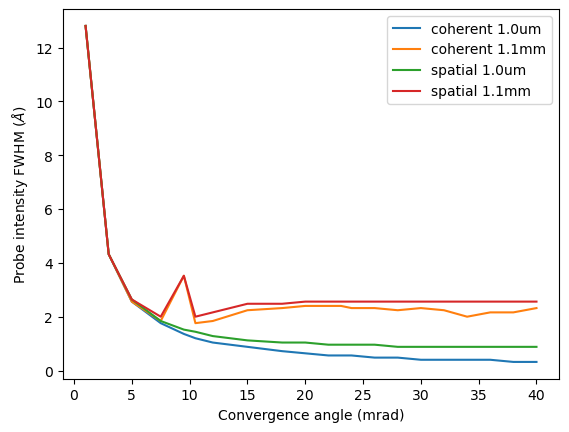

In [19]:
# Plot the FWHM for completeness, it's totally inadequate for large Cs probe because they're very sharp but with long tails
plt.figure()
plt.plot(convergence_angles, fwhm_coherent.get().T, label=['coherent 1.0um', 'coherent 1.1mm'])
plt.plot(convergence_angles, fwhm_spatial.get().T, label=['spatial 1.0um', 'spatial 1.1mm'])
plt.legend()
plt.ylabel('Probe intensity FWHM ($\AA$)')
plt.xlabel('Convergence angle (mrad)')
plt.show()

In [20]:
# Save the probe intensity images as reference
int_list = [intensity_coherent, intensity_temporal, intensity_spatial, intensity_temporal_spatial]
modes = ['temporal_spatial'] #'coherent', 'temporal', 'spatial', 
Cs_list = ['1.0um', '1.1mm']
for i, mode in enumerate(modes):
    os.makedirs(os.path.join(output_dir, mode), exist_ok=True)
        
    intensity = int_list[i]
    imwrite(os.path.join(output_dir, mode, f'STEM_probes_int_200kV_df{df}Ang_Cs_1.0um.tif'), intensity[0].array.get()) 
    imwrite(os.path.join(output_dir, mode, f'STEM_probes_int_200kV_df{df}Ang_Cs_1.1mm.tif'), intensity[1].array.get())

In [21]:
# Choose the probe to measure d50 and other metrics
intensity = intensity_temporal_spatial.array.get()

probe_d50_array = np.zeros(intensity.shape[:2])
probe_d90_array = np.zeros(intensity.shape[:2])
probe_FWHM_array = np.zeros(intensity.shape[:2])
for i in range(intensity.shape[0]): # Cs dimension
    for j in range(intensity.shape[1]): # Alpha dimension
        D50, D90, radius_rms, FWHM, radial_profile, radial_sum, fig = get_blob_size(real_space_sampling, intensity[i,j], False)
        probe_d50_array[i,j] = D50
        probe_d90_array[i,j] = D90
        probe_FWHM_array[i,j] = FWHM
    

In [22]:
probe_FWHM_array

array([[12.76,  4.28,  2.6 ,  1.8 ,  1.48,  1.4 ,  1.24,  1.08,  1.  ,
         1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ,  1.  ],
       [12.76,  4.28,  2.6 ,  1.96,  3.48,  1.96,  2.12,  2.44,  2.52,
         2.52,  2.52,  2.52,  2.52,  2.52,  2.52,  2.52,  2.52,  2.52,
         2.52,  2.52,  2.6 ]])

In [23]:
probe_d50_array

array([[12.68,  4.44,  2.76,  1.96,  1.64,  1.56,  1.48,  1.32,  1.24,
         1.16,  1.16,  1.16,  1.16,  1.16,  1.16,  1.24,  1.24,  1.24,
         1.24,  1.32,  1.32],
       [12.68,  4.44,  2.84,  2.76,  5.96,  8.84, 13.56, 25.96, 45.08,
        61.64, 71.8 , 73.96, 75.48, 79.56, 85.72, 85.8 , 89.8 , 90.12,
        91.96, 93.16, 93.64]])

# 04.02 Grab ptycho object for the resolution plot (Fig 3a)

In [24]:
# Get object image (Parsing from abTEM output)

data_dir = 'data/20231219_ptycho_recon_kmax4/static_temporal_spatial/'
folder_list = os.listdir(data_dir)

dp_str = "dp_1024_blur_0px"
dose_str = "dose_1.0e+08"

ptycho_uncorrected_folder_list = []
ptycho_corrected_folder_list = []

ptycho_uncorrected_folder_list = [item for item in folder_list if "Cs_1.1mm" in item and dp_str in item and dose_str in item and os.path.isdir(os.path.join(data_dir, item))]
ptycho_corrected_folder_list   = [item for item in folder_list if "Cs_1.0um" in item and dp_str in item and dose_str in item and os.path.isdir(os.path.join(data_dir, item))]

ptycho_uncorrected_folder_list = natural_sort(ptycho_uncorrected_folder_list)
ptycho_corrected_folder_list = natural_sort(ptycho_corrected_folder_list)

filename_path = "/1/roi_1_Ndp_1024/MLs_L1_p16_g64_dpFlip_T/Niter500.mat"
ptycho_convergence_angles = [1, 3, 5, 7.5, 9.5, 10.5, 12, 15, 18, 20, 22, 23.1, 24, 26, 28, 30, 32, 34, 36, 38, 40] # Note that although we load all the results, we'll likely only plot from 5 mrad and beyond
ptycho_px_size = 0.12 # Ang

In [25]:
ptycho_d50_array = np.zeros((2, len(ptycho_convergence_angles)))
ptycho_d90_array = np.zeros((2, len(ptycho_convergence_angles)))
ptycho_FWHM_array = np.zeros((2, len(ptycho_convergence_angles)))
ptycho_corrected_image_list = []
ptycho_uncorrected_image_list = []

# This will take a few minutes, note that we will assume both list have the same length later
for i, ptycho_folder_list in enumerate([ptycho_corrected_folder_list, ptycho_uncorrected_folder_list]):
    
    for folder in ptycho_folder_list:

        mat_contents = sio.loadmat(os.path.join(data_dir, folder + filename_path), squeeze_me=True, simplify_cells=True)
        complex_object  = mat_contents['object']
        object_ROI_idx  = mat_contents['p']['object_ROI']
        x_start, x_end, y_start, y_end = object_ROI_idx[0][0]-1, object_ROI_idx[0][-1], object_ROI_idx[1][0]-1, object_ROI_idx[1][-1]
        complex_object_cropped = complex_object[x_start-1:x_end, y_start-1:y_end]
        image = np.angle(complex_object_cropped)
        
        if i == 0:
            ptycho_corrected_image_list.append(image)
        else:
            ptycho_uncorrected_image_list.append(image)

In [26]:
# Save the image stacks
image_array = np.array([ptycho_corrected_image_list, ptycho_uncorrected_image_list])

imwrite(f'data/Fig_3a_ptycho_objects/20231219_kmax4_static_temporal_spatial_ptycho_obj_Cs_1.0um_{dp_str}_{dose_str}_p16_iter500_stack.tif', np.float32(image_array[0]))
imwrite(f'data/Fig_3a_ptycho_objects/20231219_kmax4_static_temporal_spatial_ptycho_obj_Cs_1.1mm_{dp_str}_{dose_str}_p16_iter500_stack.tif', np.float32(image_array[1]))

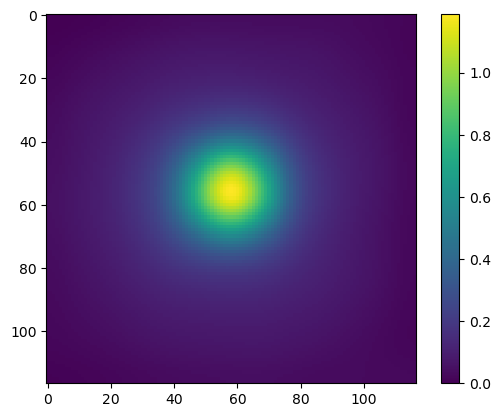

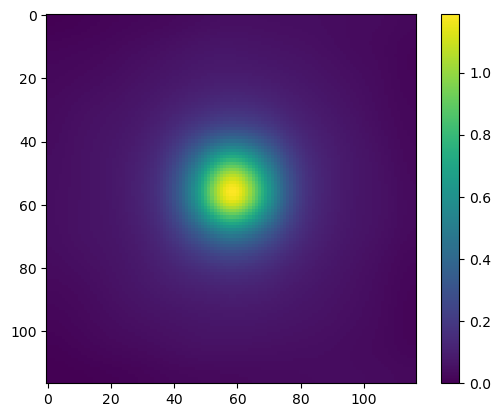

In [27]:
zoom_factor = 9
search_coords = [[127,121], [125,119]] # This is the initial search coordinate
search_window_size = 13 # Let's do odd number window for better centering
integrate_window_size = 13 

for i in range(image_array.shape[0]): # Cs dimension
    for j in range(image_array.shape[1]): # Alpha dimension
        search_coord = search_coords[i]
        search_window = image_array[i,j][search_coord[0]-search_window_size//2:search_coord[0]+search_window_size//2+1, 
                                         search_coord[1]-search_window_size//2:search_coord[1]+search_window_size//2+1]
        search_window = search_window - search_window.min()
        
        # Get the center of mass inside the search_window to realign the integration window
        y_indices, x_indices = np.indices(search_window.shape)
        total_mass = np.sum(search_window)
        y_com = np.sum(y_indices * search_window) / total_mass
        x_com = np.sum(x_indices * search_window) / total_mass
        shift_y = np.round(y_com - search_window_size//2).astype(int)
        shift_x = np.round(x_com - search_window_size//2).astype(int)
        integrate_coord = [search_coord[0] + shift_y, search_coord[1] + shift_x]
        
        #print(integrate_coord)
        # Get the new integration window center on COM
        blob = image_array[i,j][integrate_coord[0]-search_window_size//2:integrate_coord[0]+search_window_size//2+1, 
                                integrate_coord[1]-search_window_size//2:integrate_coord[1]+search_window_size//2+1]
        blob = blob - blob.min()

        # Calculate the d50
        blob = ndimage.zoom(blob, zoom_factor ,order=3)
        D50, D90, radius_rms, FWHM, radial_profile, radial_sum, fig = get_blob_size(ptycho_px_size / zoom_factor, blob, False)
        
        ptycho_d50_array[i,j] = D50
        ptycho_d90_array[i,j] = D90
        ptycho_FWHM_array[i,j] = FWHM
        if j == 10:
            plt.figure()
            plt.imshow(blob)
            plt.colorbar()
            plt.show()

In [28]:
print(ptycho_d50_array[0])
print(ptycho_d50_array[1])

print(ptycho_FWHM_array[0])
print(ptycho_FWHM_array[1])

[1.24       1.24       0.6        0.57333333 0.54666667 0.57333333
 0.54666667 0.57333333 0.6        0.6        0.62666667 0.68
 0.73333333 0.81333333 0.84       0.86666667 0.86666667 0.89333333
 0.89333333 0.92       0.92      ]
[1.26666667 1.24       0.62666667 0.6        0.57333333 0.57333333
 0.54666667 0.57333333 0.57333333 0.57333333 0.6        0.65333333
 0.68       0.78666667 0.92       0.86666667 0.94666667 0.97333333
 0.94666667 0.92       0.92      ]
[2.2        2.2        0.36       0.36       0.33333333 0.33333333
 0.33333333 0.36       0.36       0.36       0.36       0.36
 0.36       0.38666667 0.41333333 0.46666667 0.46666667 0.49333333
 0.54666667 0.73333333 0.78666667]
[2.2        2.2        0.46666667 0.41333333 0.36       0.36
 0.33333333 0.36       0.36       0.33333333 0.33333333 0.30666667
 0.30666667 0.33333333 0.36       0.97333333 1.02666667 1.08
 1.08       1.05333333 1.02666667]


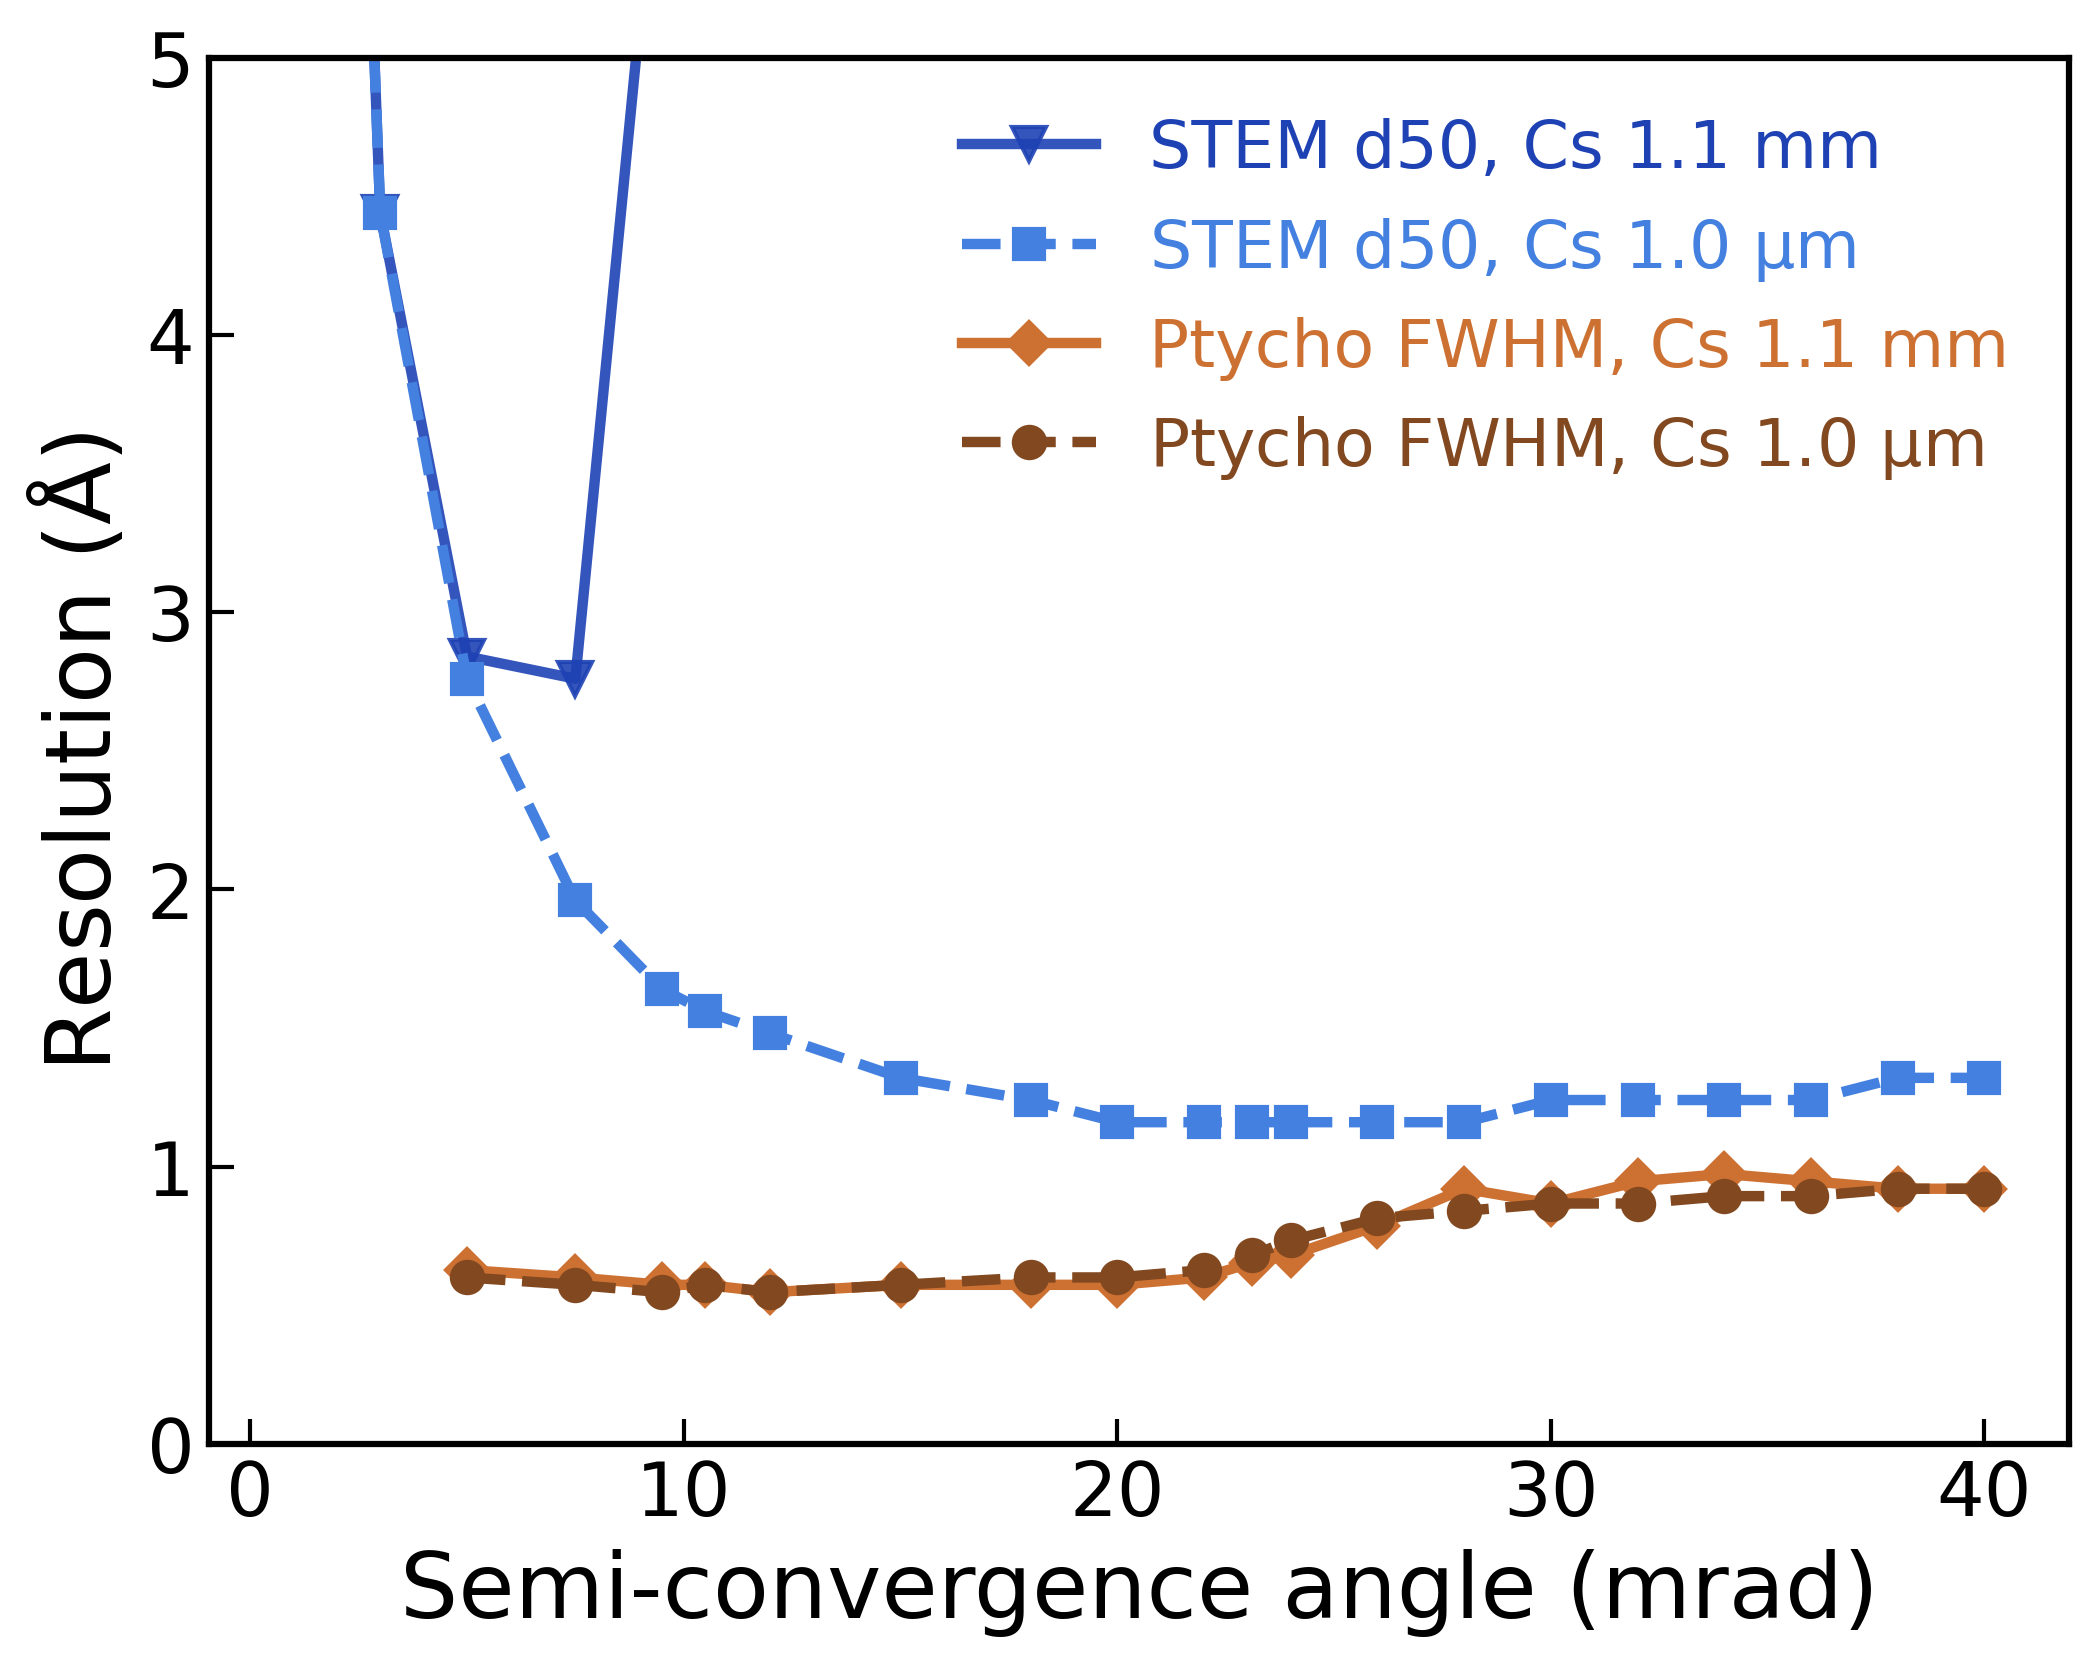

In [29]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(convergence_angles, probe_d50_array[1], label='STEM d50, Cs 1.1 mm', marker='v', c='#1E42B4', linestyle='solid', alpha = 0.90, linewidth=2.5, markersize=8) 
plt.plot(convergence_angles, probe_d50_array[0], label='STEM d50, Cs 1.0 $\mathrm{\mu}$m', marker='s', c='#4480E0', linestyle='dashed', linewidth=2.5, markersize=7) 
plt.plot(ptycho_convergence_angles[2:], ptycho_d50_array[1][2:], label='Ptycho FWHM, Cs 1.1 mm', marker='D', c='#CD7133', linestyle='solid', linewidth=2.5, markersize=7)
plt.plot(ptycho_convergence_angles[2:], ptycho_d50_array[0][2:], label='Ptycho FWHM, Cs 1.0 $\mathrm{\mu}$m', marker='o', c='#824820', linestyle='dashed', linewidth=2.5, markersize=7.5)

legend = plt.legend(loc = 1, fontsize=16, labelcolor='linecolor') 
legend.get_frame().set_linewidth(0)
plt.ylabel('Resolution ($\mathrm{\AA}$)', fontsize=22)
plt.xlabel('Semi-convergence angle (mrad)', fontsize=22)
# Increase the tick font size
plt.tick_params(axis='both', which='both', labelsize=18, width=1, length=6, direction='in')
plt.ylim(ymin=0, ymax=5)

# Make the spines (edges) of the plot thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)

plt.savefig(f'figure_components/Fig_3a_static_temporal_spatial_{dp_str}_{dose_str}_nolegend_edge_colortext_ptycho.png') 

# 05.01 Preprocess the potential into ground truth transmission funtion for SSIM

In [30]:
# Load potential and rescale px size
potential_path = 'data/intermediate_files/potential_static_sum_dx0.08Ang.tif'
potential_image = imread(potential_path, dtype='float64')

# Physical Constants
PLANCKS = 6.62607015E-34 # m^2*kg / s
REST_MASS_E = 9.1093837015E-31 # kg
CHARGE_E = 1.602176634E-19 # coulomb 
SPEED_OF_LIGHT = 299792458 # m/s

# Useful constants in EM unit 
hc = PLANCKS * SPEED_OF_LIGHT / CHARGE_E*1E-3*1E10 # 12.398 keV-Ang, h*c
REST_ENERGY_E = REST_MASS_E*SPEED_OF_LIGHT**2/CHARGE_E*1E-3 # 511 keV, m0c^2

# Experimental conditions
acceleration_voltage = 200 # kV

# Derived values
gamma = 1 + acceleration_voltage / REST_ENERGY_E # m/m0 = 1 + e*V/m0c^2, dimensionless, Lorentz factor
v_over_c = np.sqrt(1-1/gamma**2) # % of speed of light
wavelength = hc/np.sqrt((2*REST_ENERGY_E + acceleration_voltage)*acceleration_voltage) # Angstrom, lambda = hc/sqrt((2*m0c^2 + e*V)*e*V))
sigma = 2*np.pi*gamma*REST_MASS_E*CHARGE_E*wavelength/PLANCKS**2 * 1E-20 * 1E3 # interaction parameter, 2 pi*gamma*m0*e*lambda/h^2, 1/kV-Ang
transmission_function = np.exp(1j * sigma*potential_image/1000) #1000 for kV -> V
phase_shift = np.angle(transmission_function)

sio.savemat('data/intermediate_files/transmission_static_dx0.08Ang.mat', {'object':transmission_function}) # For SSIM measurement, it's using a complex object so potential would need to be processed into the transmission function

### Note
Run the `p04_measure_SSIM.m` script to calculate the SSIM using the PtychoShelves utils functions

# 05.02 Read and plot the SSIMs

In [31]:
# Setup data path
data_dir = 'data/Fig_3b_matlab_ssim_lines/'
data_list = os.listdir(data_dir)

In [32]:
# This will be executed for different doses

dose_str = "1.0e+07"
mode_str = "static_temporal_spatial" 
plot_scale = 'abs' #abs, auto

ptycho_corrected_folder_512_list = []
ptycho_corrected_folder_256_list = []
ptycho_corrected_folder_128_list = []
ptycho_uncorrected_folder_512_list = []
ptycho_uncorrected_folder_256_list = []
ptycho_uncorrected_folder_128_list = []

ptycho_corrected_folder_512_list   = [item for item in data_list if mode_str in item and "Cs_1.0um_dp_512" in item and dose_str in item]
ptycho_corrected_folder_256_list   = [item for item in data_list if mode_str in item and "Cs_1.0um_dp_256" in item and dose_str in item]
ptycho_corrected_folder_128_list   = [item for item in data_list if mode_str in item and "Cs_1.0um_dp_128" in item and dose_str in item]
ptycho_uncorrected_folder_512_list = [item for item in data_list if mode_str in item and "Cs_1.1mm_dp_512" in item and dose_str in item]
ptycho_uncorrected_folder_256_list = [item for item in data_list if mode_str in item and "Cs_1.1mm_dp_256" in item and dose_str in item]
ptycho_uncorrected_folder_128_list = [item for item in data_list if mode_str in item and "Cs_1.1mm_dp_128" in item and dose_str in item]

SSIM_mat_path_lists = [ ptycho_corrected_folder_512_list, 
                        ptycho_corrected_folder_256_list,
                        ptycho_corrected_folder_128_list,
                        ptycho_uncorrected_folder_512_list,
                        ptycho_uncorrected_folder_256_list,
                        ptycho_uncorrected_folder_128_list]

label_list = ['Cs 1.0 $\mathrm{\mu}$m, Det. 512 px',
              'Cs 1.0 $\mathrm{\mu}$m, Det. 256 px',
              'Cs 1.0 $\mathrm{\mu}$m, Det. 128 px',
              'Cs 1.1 mm, Det. 512 px',
              'Cs 1.1 mm, Det. 256 px',
              'Cs 1.1 mm, Det. 128 px'
              ]

In [33]:
ptycho_convergence_angles = [1, 3, 5, 7.5, 9.5, 10.5, 12, 15, 18, 20, 22, 23.1, 24, 26, 28, 30, 32, 34, 36, 38, 40] 
SSIM_arr = np.zeros((len(SSIM_mat_path_lists), len(ptycho_convergence_angles)))
image_arr = np.zeros((len(SSIM_mat_path_lists), len(ptycho_convergence_angles), 150, 150))

for i, SSIM_mat_path in enumerate(SSIM_mat_path_lists):
    print(f"Loading {SSIM_mat_path[0]}")
    mat = sio.loadmat(os.path.join(data_dir, SSIM_mat_path[0]), simplify_cells = True)
    SSIM_arr[i] = np.squeeze(mat['ssims'])

    for j in range(len(ptycho_convergence_angles)-2): # Skip the first 2 convergence angles because it's really nothing there
        shape = mat['subimages_ph'][j+2].shape
        image_arr[i, j+2, :shape[0], :shape[1]] = mat['subimages_ph'][j+2]

Loading ssim_static_temporal_spatial_Cs_1.0um_dp_512_blur_0px_dose_1.0e+07ePerAng2.mat
Loading ssim_static_temporal_spatial_Cs_1.0um_dp_256_blur_0px_dose_1.0e+07ePerAng2.mat
Loading ssim_static_temporal_spatial_Cs_1.0um_dp_128_blur_0px_dose_1.0e+07ePerAng2.mat
Loading ssim_static_temporal_spatial_Cs_1.1mm_dp_512_blur_0px_dose_1.0e+07ePerAng2.mat
Loading ssim_static_temporal_spatial_Cs_1.1mm_dp_256_blur_0px_dose_1.0e+07ePerAng2.mat
Loading ssim_static_temporal_spatial_Cs_1.1mm_dp_128_blur_0px_dose_1.0e+07ePerAng2.mat


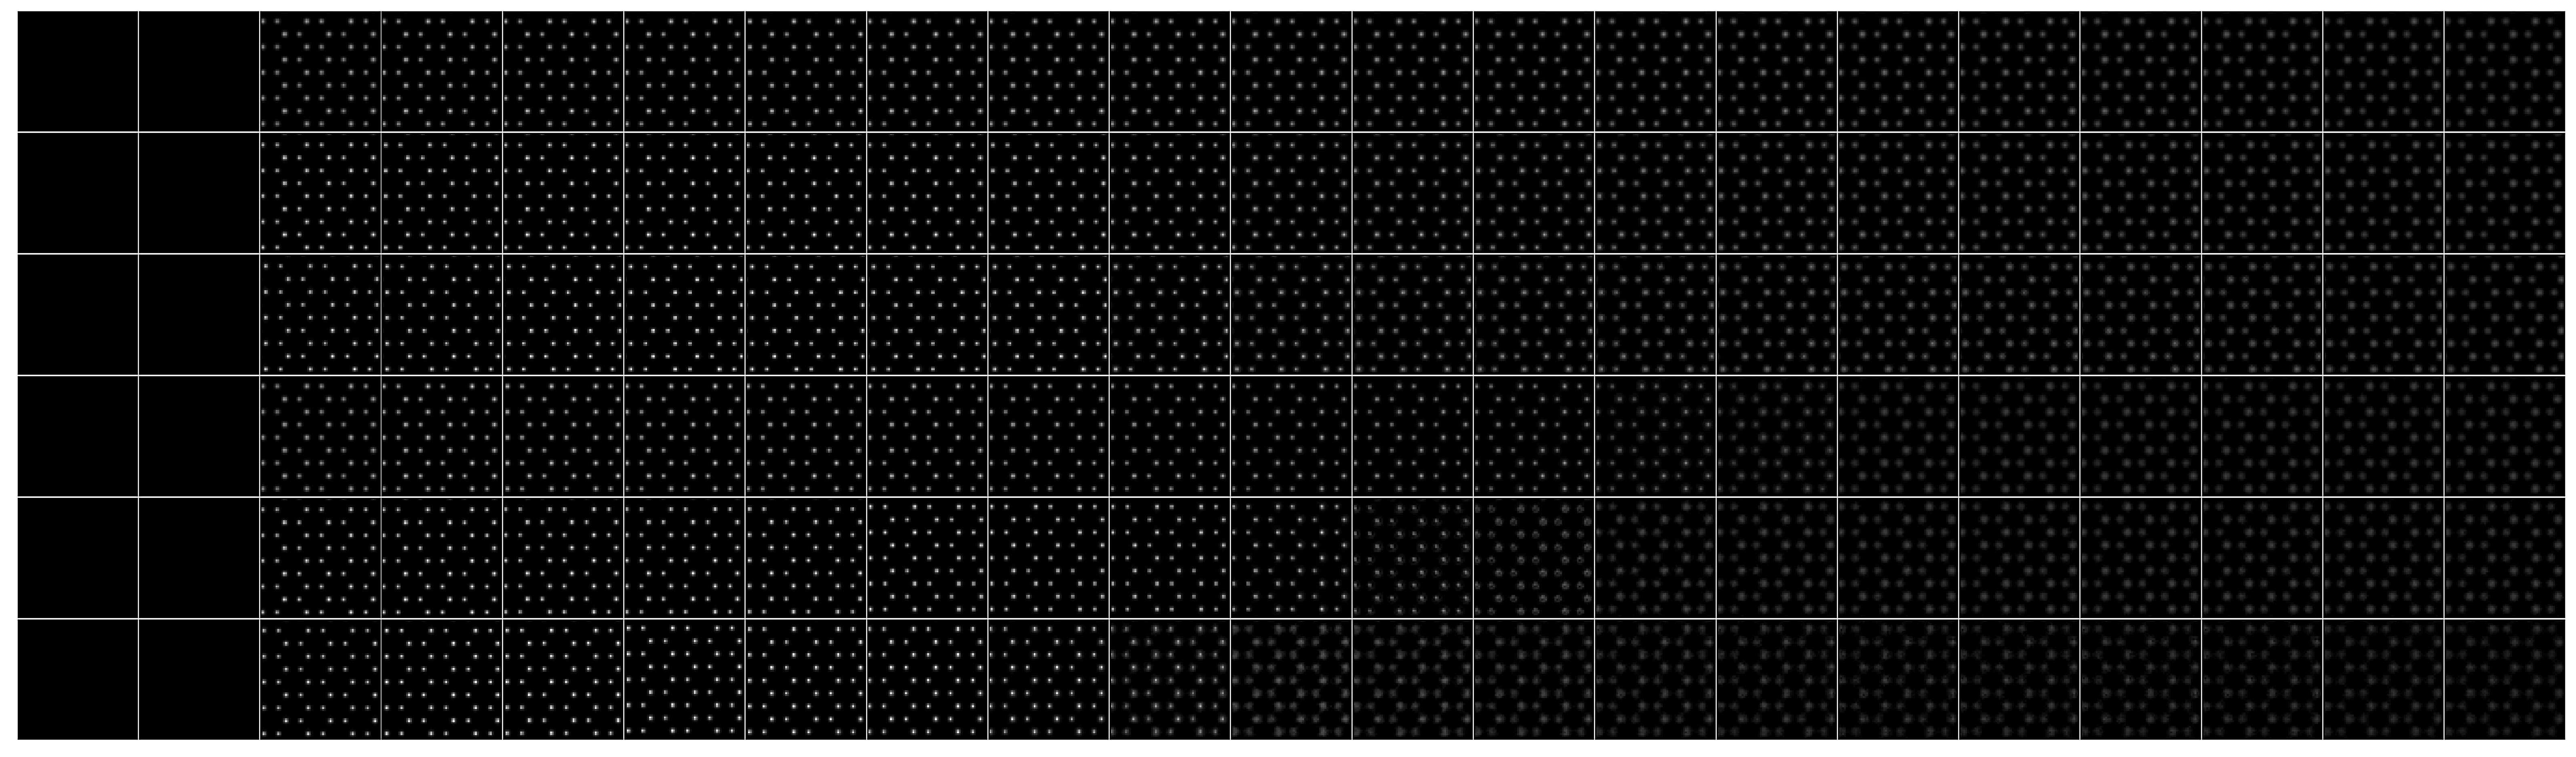

In [34]:
# Visualize the loaded phase images
fig, axs = plt.subplots(len(SSIM_mat_path_lists),len(ptycho_convergence_angles),figsize=(21, 6), dpi=300)
plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Adjust the gap here

center = [32,32]
window_length = 64
for i in range(len(SSIM_mat_path_lists)):
    for j in range (len(ptycho_convergence_angles)):
        
        crop_obj = image_arr[i, j, center[0]-window_length//2:center[0]+window_length//2, center[1]-window_length//2:center[1]+window_length//2]
        if plot_scale == 'abs':
            axs[i,j].imshow(crop_obj, cmap='gray', vmin=0, vmax=1.12)
        else:
            axs[i,j].imshow(crop_obj, cmap='gray')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove outer white space

if plot_scale =='abs':
    plt.savefig(f'data//Fig_3b_obj_montage/{mode_str}_blur_0px_{dose_str}ePerAng2_vmin_0_vmax_1.12.png', bbox_inches='tight', pad_inches=0)
else:
    plt.savefig(f'data//Fig_3b_obj_montage/{mode_str}_blur_0px_{dose_str}ePerAng2_auto.png', bbox_inches='tight', pad_inches=0)

plt.show()


# The clean version of Fig 3b for actual paper

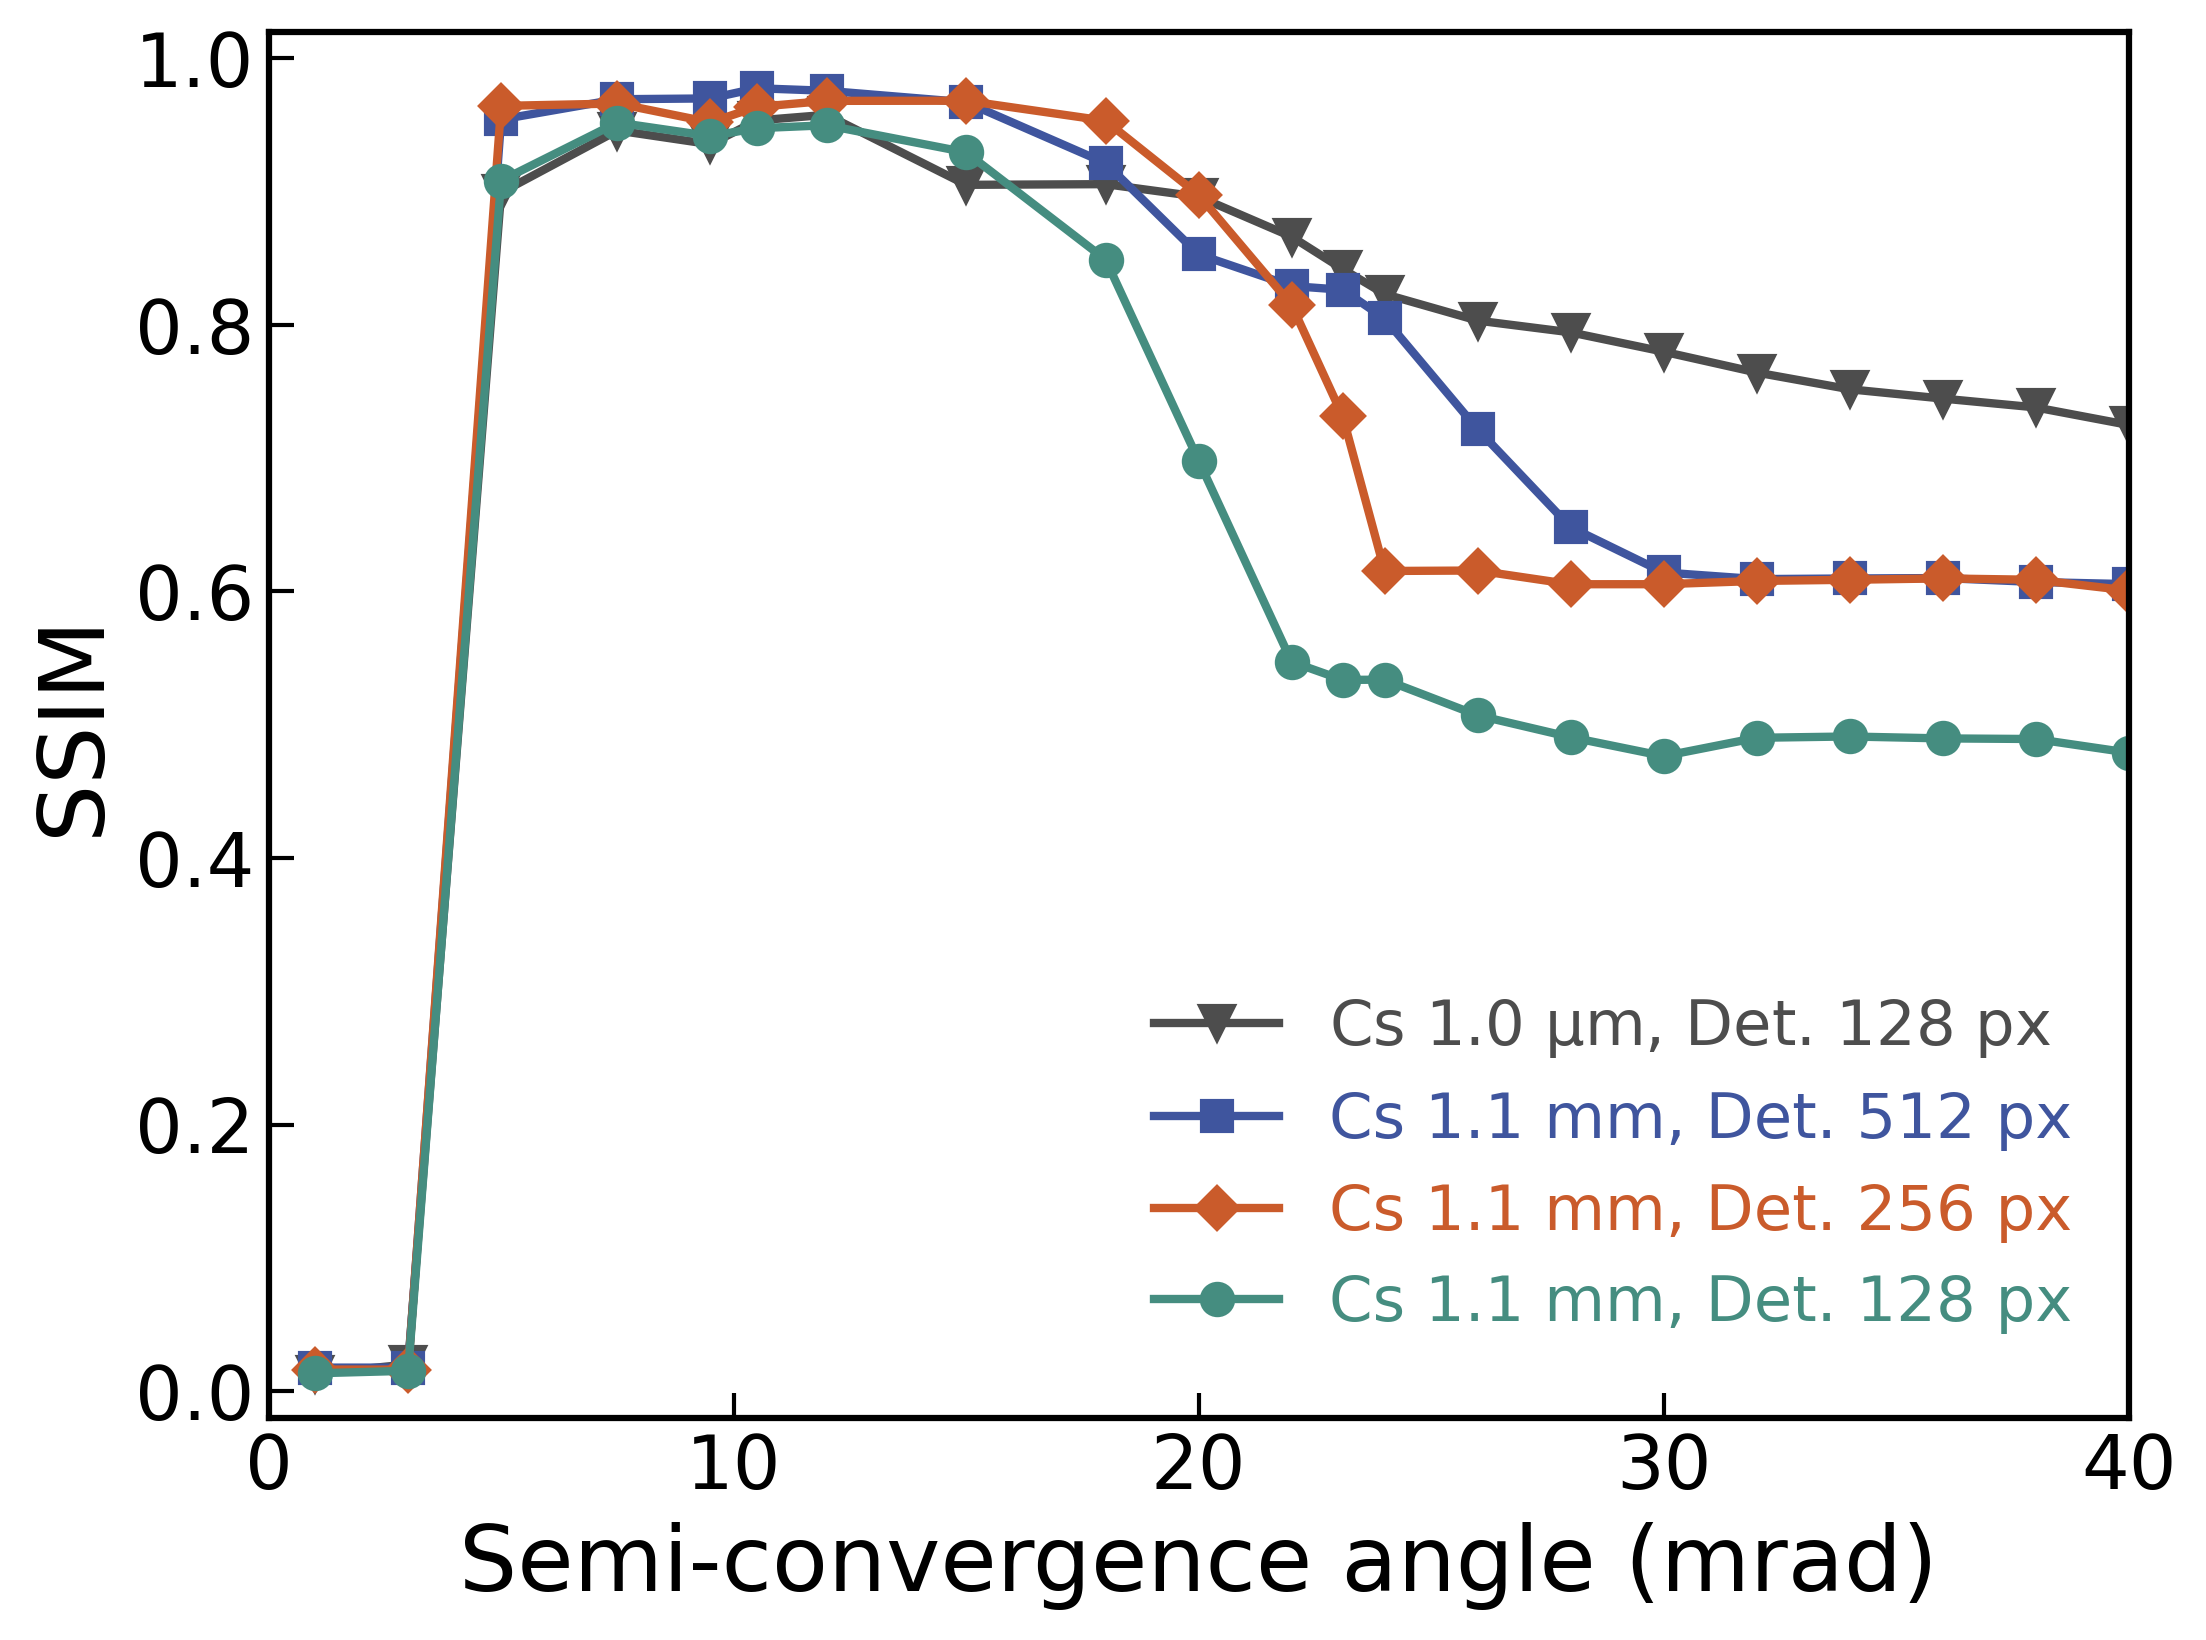

In [35]:
markers = ['x', 'd', 'v', 's', 'D', 'o']  # You can expand this list as needed
markersizes = [7,7,8,7,7,7.5]
colors = ['C0', 'C1', '#4d4d4d', '#3f559e', '#ca5b2b', '#458d80'] 
select_idx = [2, 3, 4, 5]
plt.figure(figsize=(8,6), dpi=300)
for i, (ssim, label, marker, markersize, color) in enumerate(zip(SSIM_arr, label_list, markers, markersizes, colors)):
    if i in select_idx:
        plt.plot(ptycho_convergence_angles, ssim, label=label, marker=marker, color = color, linewidth=2, markersize=markersize)
    

plt.ylabel('SSIM', fontsize=22)
plt.xlabel('Semi-convergence angle (mrad)', fontsize=22)
plt.ylim(ymin=-0.02, ymax=1.02)
plt.xlim(xmin=0, xmax=40)



# Plotting the legend with fractional control
legend = plt.legend(loc='lower right', bbox_to_anchor=(1, 0.02), fontsize=15, labelcolor='linecolor')
legend.get_frame().set_linewidth(0)

# Increase the tick font size
plt.tick_params(axis='both', which='both', labelsize=18, width=1, length=6, direction='in')
# Set the x-ticks to specific values
plt.xticks([0, 10, 20, 30, 40])

# Make the spines (edges) of the plot thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    
plt.savefig(f'figure_components/Fig_3b_{mode_str}_blur_0px_{dose_str}ePerAng2_clean_nolegend_edge_colortext.png')
plt.show()